In [119]:
from soupsieve.css_types import pickle_register

"""
Needed environment:

We have to download the anaconda or miniconda distribution, then execute these commands:

    1. Create a Conda environment:
        conda create --name tf_gpu python=3.10
    2. Activate the environment:
        conda activate tf_gpu
    3. Install CUDA and cuDNN:
        conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1
    4. Install TensorFlow:
        pip install tensorflow==2.10

Needed libraries:

   pip install notebook opencv-python matplotlib scikit-image seaborn scikit-learn

If the project still doesn't use the GPU, follow these steps:

    1. Download CUDA 11.2 and cuDNN 8.1 from the official websites.
    2. After installing CUDA, copy the cuDNN files (bin, include, lib) into the appropriate CUDA directories:
        - bin -> C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\bin
        - include -> C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\include
        - lib -> C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\lib
    3. Add the following to your system's environment variables:
        - CUDA_HOME: C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2
        - CUDA_PATH: C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2
        - CUDA_PATH_V11_2: C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2
    4. Restart the PC to apply changes.
"""

# TensorFlow and Keras imports
import tensorflow as tf
from keras.backend import clear_session
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Lambda, LeakyReLU, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras.backend as K

# Standard library imports
import gc
import os
import random
import itertools
import cProfile

# Image processing and plotting imports
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage import filters

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, \
    f1_score
from sklearn.manifold import TSNE

gc.collect()
clear_session()

In [120]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_visible_devices(gpus[0], 'GPU')
            print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
            print("Available GPUs: ", tf.config.list_physical_devices('GPU'))
    except RuntimeError as e:
        print(e)
else:
    print("GPU was not detected.")

print("Available GPUs: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [121]:
root_path = "./SignatureDatasets/"

datasets = {
    "Cedar": os.path.join(root_path, "CEDAR", "CEDAR"),
    "BHSig260-Bengali": os.path.join(root_path, "BHSig260-Bengali", "BHSig260-Bengali"),
    "BHSig260-Hindi": os.path.join(root_path, "BHSig260-Hindi", "BHSig260-Hindi")
}

choosen_dataset = datasets["BHSig260-Hindi"]


In [122]:
def get_images_from_dataset(path, forgery_count=24, genuine_count=24):
    """
    Extracts genuine and forgery images from the dataset.

    Parameters:
        path (str): The path to the dataset directory.
        forgery_count (int): Number of forgery images per directory.
        genuine_count (int): Number of genuine images per directory.

    Returns:
        tuple: Two dictionaries containing genuine and forgery images.
    """
    genuine_images = {}
    forgery_images = {}

    for directory in os.listdir(path):
        dir_path = os.path.join(path, directory)
        if os.path.isdir(dir_path):
            images = os.listdir(dir_path)
            images.sort()
            if 'CEDAR' in path:
                forgery_images[directory] = images[:forgery_count]
                genuine_images[directory] = images[forgery_count:forgery_count + genuine_count]
            else:
                forgery_count = 30
                forgery_images[directory] = images[:forgery_count]
                genuine_images[directory] = images[forgery_count:forgery_count + genuine_count]

    print("Dataset name:", path.split("\\")[-1])
    print("Total number of authors:", len(genuine_images))
    print("---------------------------------")

    return genuine_images, forgery_images


In [123]:
def print_loaded_image_info(dictionary_name, images_dictionary):
    """    
    Prints out the important information about the dataset.

    Parameters:
        dictionary_name (str): Dictionary name
        images_dictionary (dict): Dictionary containing images.
    """
    print(f"{dictionary_name}:")
    print(f"Number of directories: {len(images_dictionary)}")
    total_images = sum([len(images) for images in images_dictionary.values()])
    print(f"Total images: {total_images}")
    print("---------------------------------")

In [124]:
genuine_images, forgery_images = get_images_from_dataset(choosen_dataset)
print_loaded_image_info("Genuine images", genuine_images)
print_loaded_image_info("Forgery images", forgery_images)

Dataset name: BHSig260-Hindi
Total number of authors: 160
---------------------------------
Genuine images:
Number of directories: 160
Total images: 3840
---------------------------------
Forgery images:
Number of directories: 160
Total images: 4800
---------------------------------


In [125]:
IMG_HEIGHT, IMG_WIDTH = 155, 220  # Set your image dimensions here

In [126]:
def center_image_on_canvas(ref_image, target_size):
    """
    Create a dynamically sized canvas for an input image for optimal resizing.

    Args:
        ref_image (np.ndarray): The input image (grayscale or binary).
        target_size (tuple): Desired size for CNN input (height, width).

    Returns:
        resized_image (np.ndarray): Image resized to the model input size.
    """
    target_height, target_width = target_size
    cropped_height, cropped_width = ref_image.shape[:2]

    aspect_ratio = cropped_width / cropped_height

    if aspect_ratio > (target_width / target_height):
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    resized_image = cv2.resize(ref_image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    top_pad = (target_height - new_height) // 2
    bottom_pad = target_height - new_height - top_pad
    left_pad = (target_width - new_width) // 2
    right_pad = target_width - new_width - left_pad

    final_canvas = cv2.copyMakeBorder(resized_image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT,value=0)

    return final_canvas

def preprocessing(image_path, img_size, plot=False, training=False):
    steps = {}

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    steps['Original Image'] = image

    if training:
        brightness_shift = random.randint(-50, 50)
        image = cv2.convertScaleAbs(image, alpha=1.0, beta=brightness_shift)

        contrast_factor = random.uniform(0.8, 1.2)
        image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)

        if random.choice([True, False]): image = cv2.flip(image, 1)

        steps["Augmented image"] = image

    image = 255 - image

    image = cv2.GaussianBlur(image, (5, 5), 0)
    threshold = filters.threshold_otsu(image)
    image = np.where(image > threshold, 255, 0)
    steps['Thresholded Image'] = image

    def cropping(ref_img, padding=5):
        contours, _ = cv2.findContours(ref_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            x, y, w, h = cv2.boundingRect(np.concatenate(contours))

            x_start = max(0, x - padding)
            y_start = max(0, y - padding)
            x_end = min(ref_img.shape[1], x + w + padding)
            y_end = min(ref_img.shape[0], y + h + padding)

            return ref_img[y_start:y_end, x_start:x_end]

        return ref_img

    image = cropping(image.astype(np.uint8))
    steps['Cropped Image'] = image

    image = center_image_on_canvas(image, img_size)
    steps['Centered Image'] = image

    image = image / 255
    steps['Final Image'] = image

    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)

    if plot:
        return steps
    else:
        return image



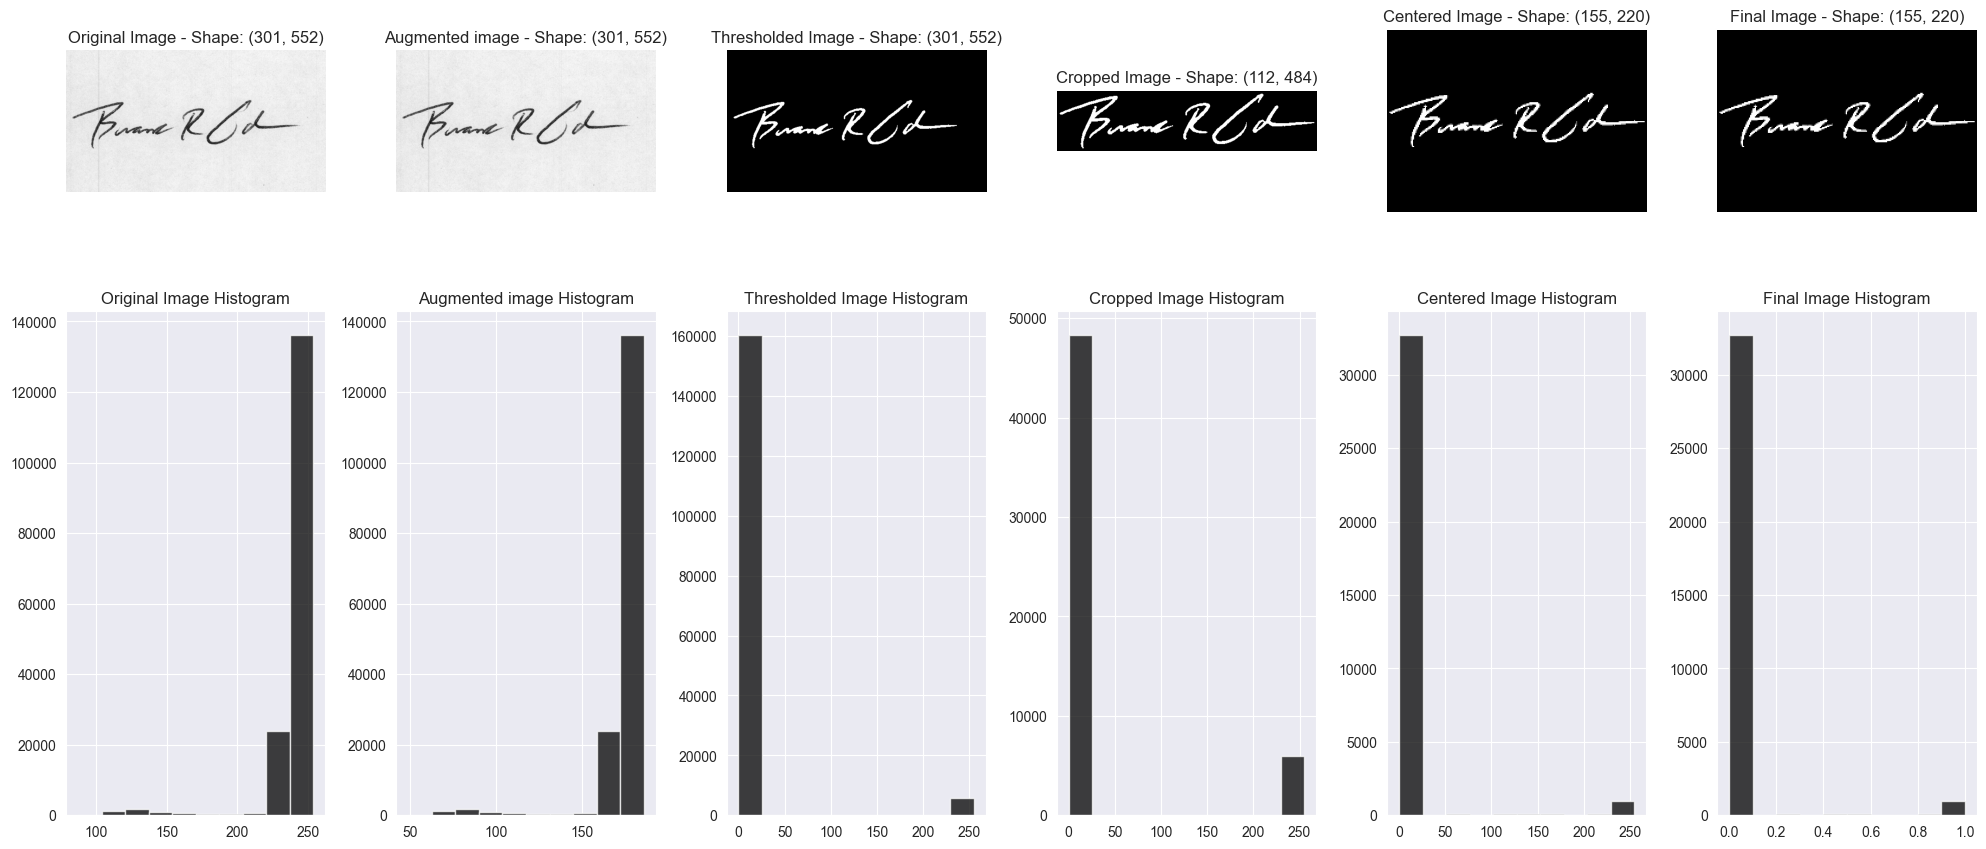

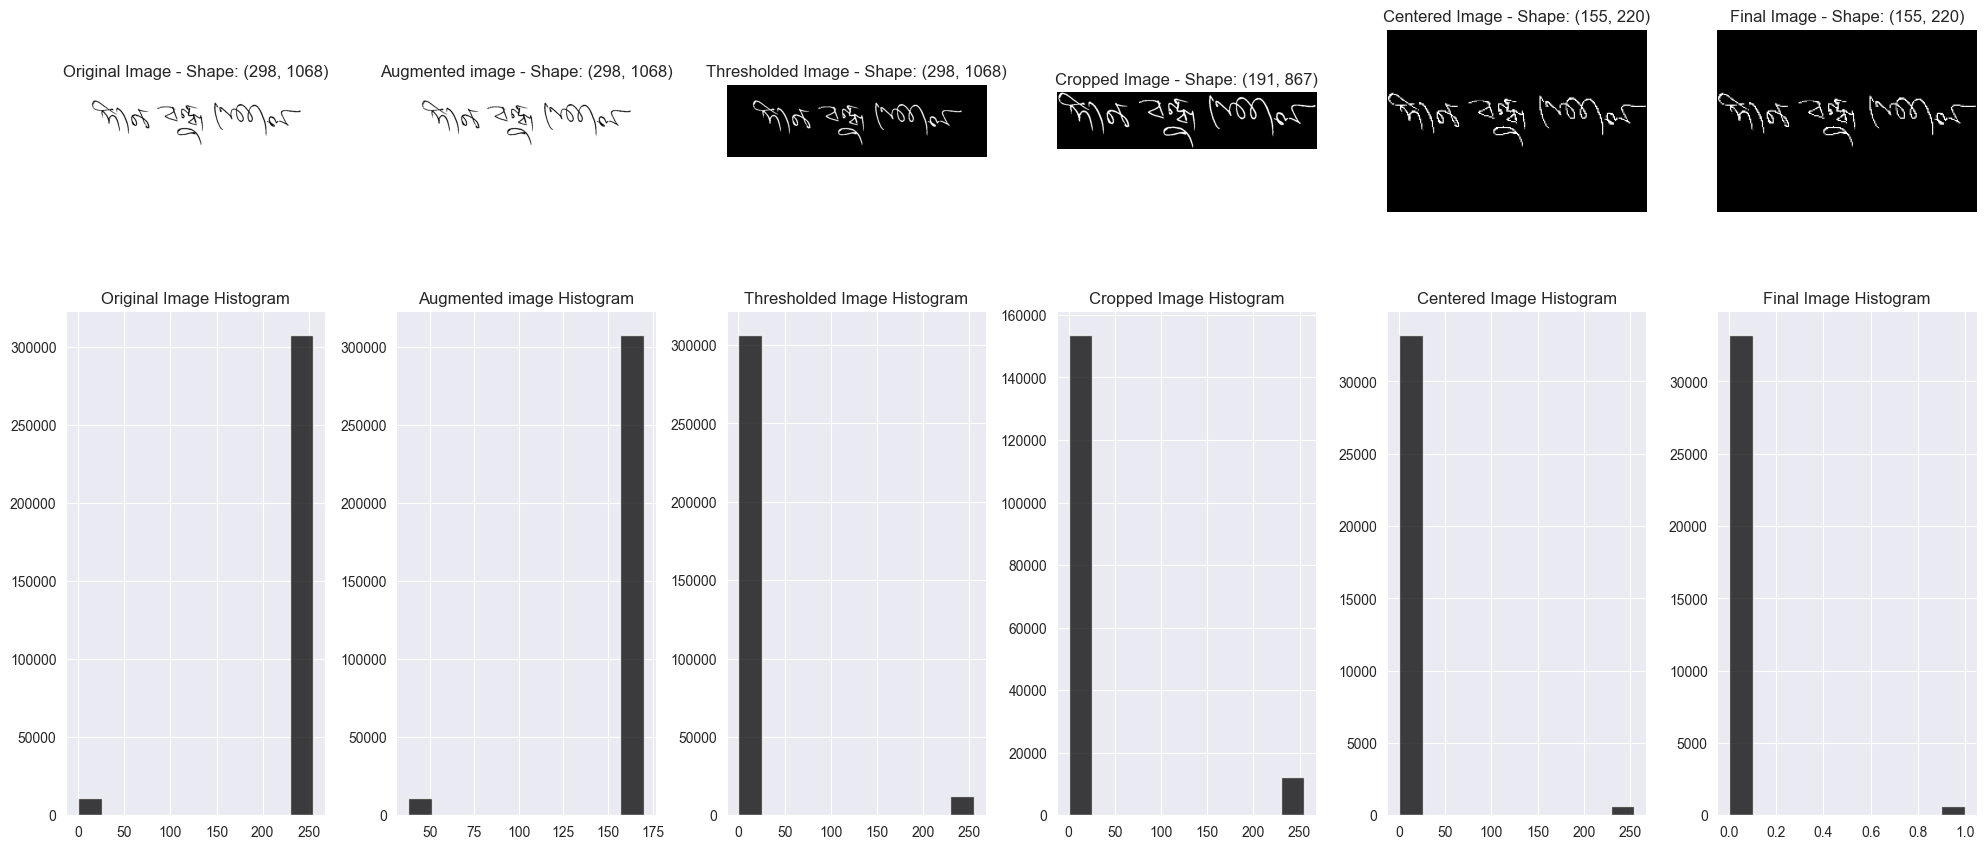

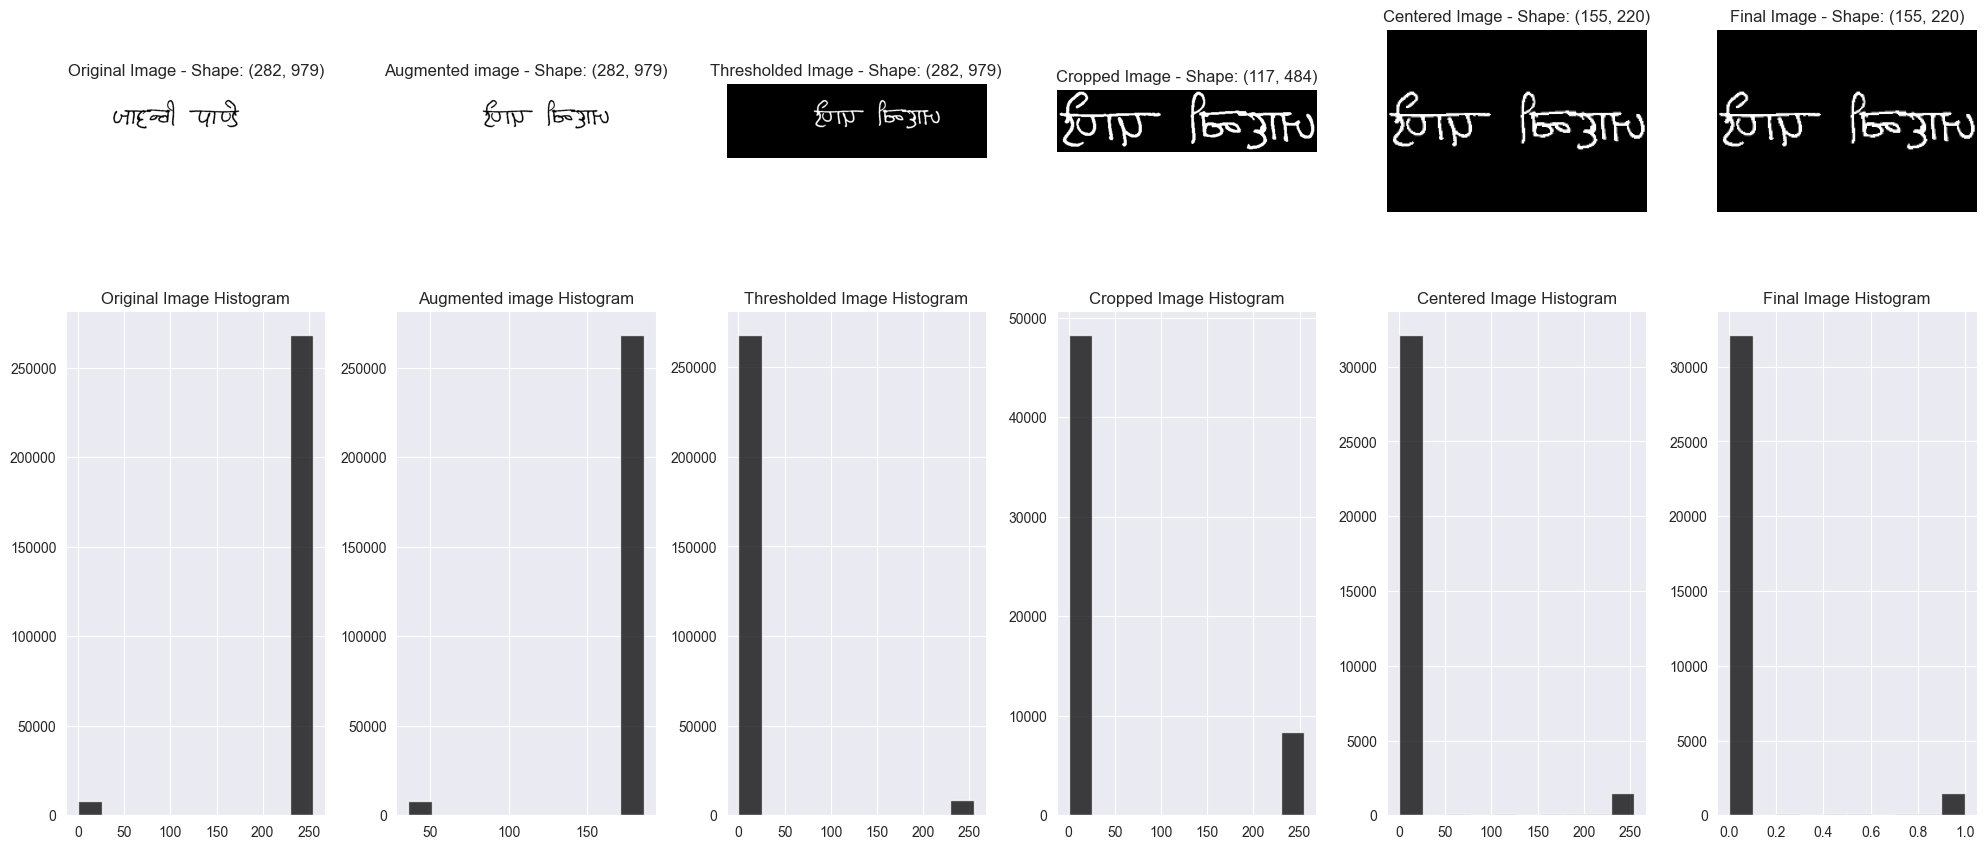

In [127]:
def visualize_preprocessing(image):
    steps = preprocessing(image, (IMG_HEIGHT, IMG_WIDTH), plot=True, training=True)

    titles = list(steps.keys())
    images = list(steps.values())

    fig, axes = plt.subplots(2, len(images), figsize=(20, 10))
    for i, (ax_img, ax_hist, img, title) in enumerate(zip(axes[0], axes[1], images, titles)):
        if isinstance(img, tf.Tensor):
            img = img.numpy().squeeze()

        ax_img.imshow(img, cmap='gray')
        ax_img.set_title(f"{title} - Shape: {img.shape}")
        ax_img.axis('off')

        ax_hist.hist(img.ravel(), bins=10, color='black', alpha=0.75)
        ax_hist.set_title(f'{title} Histogram')

    plt.tight_layout()
    plt.show()

author = "15"

genuine_image_path1 = f"SignatureDatasets/CEDAR/CEDAR/{author}/original_{author}_2.png"
genuine_image_path2 = f"SignatureDatasets/BHSig260-Bengali/BHSig260-Bengali/{author}/B-S-{author}-G-03.tif"
genuine_image_path3 = f"SignatureDatasets/BHSig260-Hindi/BHSig260-Hindi/{author}/H-S-{author}-F-22.tif"

visualize_preprocessing(genuine_image_path1)
visualize_preprocessing(genuine_image_path2)
visualize_preprocessing(genuine_image_path3)


In [128]:
def profile_preprocessing(): return preprocessing(genuine_image_path1, (IMG_HEIGHT, IMG_WIDTH), plot=False, training=True)


cProfile.run("profile_preprocessing()")

         188 function calls in 0.008 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 1704378756.py:1(center_image_on_canvas)
        1    0.001    0.001    0.008    0.008 1704378756.py:35(preprocessing)
        1    0.000    0.000    0.000    0.000 1704378756.py:59(cropping)
        1    0.000    0.000    0.008    0.008 910060319.py:1(profile_preprocessing)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:100(acquire)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1022(_find_and_load)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1038(_gcd_import)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:125(release)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:165(__init__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstr

In [129]:
authors = list(genuine_images.keys())

train_authors, test_authors = train_test_split(authors, test_size=0.2)
train_authors, val_authors = train_test_split(train_authors, test_size=0.1)

print(f"Number of training authors: {len(train_authors)}")
print(f"Number of testing authors: {len(test_authors)}")
print(f"Number of validation authors: {len(val_authors)}")

print("Training Authors:", train_authors)
print("Validation Authors:", val_authors)
print("Testing Authors:", test_authors)


Number of training authors: 115
Number of testing authors: 32
Number of validation authors: 13
Training Authors: ['80', '130', '75', '49', '109', '95', '126', '57', '81', '9', '69', '39', '51', '153', '132', '33', '99', '52', '91', '53', '145', '140', '8', '152', '98', '30', '55', '122', '128', '138', '104', '56', '107', '72', '31', '70', '133', '119', '87', '74', '21', '10', '26', '67', '120', '105', '7', '135', '23', '65', '90', '61', '137', '125', '157', '113', '66', '43', '117', '127', '147', '88', '158', '156', '63', '20', '24', '79', '134', '68', '76', '96', '155', '106', '142', '108', '115', '151', '54', '111', '50', '60', '12', '42', '150', '154', '77', '14', '11', '71', '32', '144', '129', '94', '46', '84', '3', '73', '45', '38', '13', '136', '29', '102', '47', '110', '17', '82', '18', '97', '121', '19', '22', '78', '58']
Validation Authors: ['34', '16', '5', '1', '83', '131', '149', '48', '146', '62', '100', '160', '93']
Testing Authors: ['15', '37', '143', '116', '2', '139',

In [130]:
def create_pairs(authors_list, dataset_path):
    """
    Create balanced pairs of genuine and forgery images for a list of authors.

    Args:
        authors_list (list): List of author IDs.
        dataset_path (str): Base directory path where the dataset is stored.

    Returns:
        tuple: A tuple containing:
            - pairs (list): List of tuples, where each tuple contains two image paths.
            - labels (list): List of labels corresponding to the pairs (0: genuine, 1: forgery).
    """
    all_pairs = []
    all_labels = []

    for author in authors_list:
        author_dir = os.path.join(dataset_path, str(author))

        if "CEDAR" in dataset_path:
            genuine_list = [f for f in os.listdir(author_dir) if f.startswith("original")]
            forgery_list = [f for f in os.listdir(author_dir) if f.startswith("forgeries")]
        else:
            genuine_list = [f for f in os.listdir(author_dir) if "-G-" in f]
            forgery_list = [f for f in os.listdir(author_dir) if "-F-" in f]

        genuine_pairs = [
            (os.path.join(author_dir, img1), os.path.join(author_dir, img2))
            for img1, img2 in itertools.combinations(genuine_list, 2)
        ]

        forgery_pairs = [
            (os.path.join(author_dir, img1), os.path.join(author_dir, img2))
            for img1, img2 in itertools.product(genuine_list, forgery_list)
        ]

        min_size = min(len(genuine_pairs), len(forgery_pairs))
        balanced_genuine = random.sample(genuine_pairs, min_size)
        balanced_forgery = random.sample(forgery_pairs, min_size)

        all_pairs.extend(balanced_genuine + balanced_forgery)
        all_labels.extend([0] * len(balanced_genuine) + [1] * len(balanced_forgery))

    return shuffle(all_pairs, all_labels)

In [131]:
def print_dataset_info(pairs, labels, dataset_name):
    """
    Prints out the important information about the dataset.

    Parameters:
        pairs (list): List of image pairs.
        labels (list): List of labels.
        dataset_name (str): Name of the dataset.
    """
    print(f"{dataset_name}:")
    print(f"Number of pairs: {len(pairs)}")
    print(f"Number of genuine pairs: {labels.count(0)}")  # 0 labels are genuine
    print(f"Number of forgery pairs: {labels.count(1)}")  # 1 labels are forgery
    print("---------------------------------")

In [132]:
train_pairs, train_labels = create_pairs(train_authors, choosen_dataset)
test_pairs, test_labels = create_pairs(test_authors, choosen_dataset)
val_pairs, val_labels = create_pairs(val_authors, choosen_dataset)

print_dataset_info(train_pairs, train_labels, "Training Set")
print_dataset_info(test_pairs, test_labels, "Testing Set")
print_dataset_info(val_pairs, val_labels, "Validation Set")

Training Set:
Number of pairs: 63480
Number of genuine pairs: 31740
Number of forgery pairs: 31740
---------------------------------
Testing Set:
Number of pairs: 17664
Number of genuine pairs: 8832
Number of forgery pairs: 8832
---------------------------------
Validation Set:
Number of pairs: 7176
Number of genuine pairs: 3588
Number of forgery pairs: 3588
---------------------------------


In [133]:
def count_and_assert_pairs_by_author(pairs, labels):
    """
    Counts the number of genuine and forgery pairs for each author
    and asserts that all authors have the same counts.

    Args:
        pairs (list): List of image pairs (paths).
        labels (list): Corresponding labels (0 for genuine, 1 for forgery).

    Returns:
        author_counts (dict): Dictionary containing the counts for each author.
    """
    from collections import defaultdict

    author_counts = defaultdict(lambda: {'genuine': 0, 'forgery': 0})

    for (img1, img2), label in zip(pairs, labels):
        file_name = os.path.basename(img1)
        if '_' in file_name:
            author_id = file_name.split("_")[1]
        else:
            author_id = file_name.split("-")[2]

        if label == 0:  # Genuine
            author_counts[author_id]['genuine'] += 1
        elif label == 1:  # Forgery
            author_counts[author_id]['forgery'] += 1

    reference_genuine = next(iter(author_counts.values()))['genuine']
    reference_forgery = next(iter(author_counts.values()))['forgery']

    for author, counts in author_counts.items():
        assert counts['genuine'] == reference_genuine, f"Author {author} has unequal genuine counts!"
        assert counts['forgery'] == reference_forgery, f"Author {author} has unequal forgery counts!"

    print(f"All authors have {reference_genuine} genuine and {reference_forgery} forgery pairs.")
    return author_counts


# Use the function
author_counts = count_and_assert_pairs_by_author(train_pairs, train_labels)

All authors have 276 genuine and 276 forgery pairs.


In [134]:
def check_pairs(pairs, labels, title, num_pairs=5):
    """
    Prints the first 100 pairs and their corresponding labels.

    Parameters:
        pairs (list): List of image pairs.
        labels (list): List of labels.
    """
    print(f"First {num_pairs} pairs in {title}:")
    for pair, label in zip(pairs[:num_pairs], labels[:num_pairs]):
        print(pair, label)


check_pairs(train_pairs, train_labels, "training Set", 10)
check_pairs(test_pairs, test_labels, "testing Set", 10)
check_pairs(val_pairs, val_labels, "validation Set", 10)

First 10 pairs in training Set:
('./SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\3\\H-S-3-G-04.tif', './SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\3\\H-S-3-F-18.tif') 1
('./SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\60\\H-S-60-G-05.tif', './SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\60\\H-S-60-F-16.tif') 1
('./SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\43\\H-S-43-G-05.tif', './SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\43\\H-S-43-G-20.tif') 0
('./SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\52\\H-S-52-G-16.tif', './SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\52\\H-S-52-F-19.tif') 1
('./SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\12\\H-S-12-G-11.tif', './SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\12\\H-S-12-G-14.tif') 0
('./SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\142\\H-S-142-G-01.tif', './SignatureDatasets/BHSig260-Hindi\\BHSig260-Hindi\\142\\H-S-142-F-14.tif') 1
('./SignatureDatasets/BHSig260-Hindi\\BHSig260-Hin

In [135]:
def check_overlaps(pairs1, pairs2):
    """
    Check for overlapping pairs between two datasets.

    Parameters:
        pairs1 (list): List of image pairs.
        pairs2 (list): List of image pairs.

    Returns:
        bool: True if there are overlapping pairs, False otherwise.
    """
    pairs1_set = set(pairs1)
    pairs2_set = set(pairs2)

    return bool(pairs1_set.intersection(pairs2_set))

overlaps_train_test = check_overlaps(train_pairs, test_pairs)
overlaps_train_valid = check_overlaps(train_pairs, val_pairs)
overlaps_test_valid = check_overlaps(test_pairs, val_pairs)

print(f"Overlapping pairs between training and testing sets: {overlaps_train_test}")
print(f"Overlapping pairs between training and validation sets: {overlaps_train_valid}")
print(f"Overlapping pairs between testing and valdiation sets: {overlaps_test_valid}")

Overlapping pairs between training and testing sets: False
Overlapping pairs between training and validation sets: False
Overlapping pairs between testing and valdiation sets: False


In [136]:
def create_tf_dataset(all_pairs, all_labels, img_h, img_w, batch_size, need_augmentation=False):
    """
    Creates a tf.data.Dataset for image pairs and labels.
    Args:
        all_pairs (list of tuples): A list of tuples containing image paths (img1_path, img2_path).
        all_labels (list): A list of labels corresponding to each pair of images.
        img_h (int): The height of the images.
        img_w (int): The width of the images.
        batch_size (int): The batch size for the dataset.
    Returns:
        tf.data.Dataset: A dataset object that yields batches of image pairs and labels.
    """

    def preprocess(pair, label):
        def process_pair(img1_path, img2_path):
            img1_path = img1_path.numpy().decode("utf-8")

            img2_path = img2_path.numpy().decode("utf-8")

            if need_augmentation:
                img1 = preprocessing(img1_path, (img_h, img_w), training=True)
                img2 = preprocessing(img2_path, (img_h, img_w), training=True)
            else:
                img1 = preprocessing(img1_path, (img_h, img_w))
                img2 = preprocessing(img2_path, (img_h, img_w))

            return img1, img2

        img1, img2 = tf.py_function(
            func=process_pair,
            inp=[pair[0], pair[1]],
            Tout=(tf.float32, tf.float32)
        )

        label = tf.cast(label, tf.float32)

        return (img1, img2), label

    dataset = tf.data.Dataset.from_tensor_slices((all_pairs, all_labels))

    dataset = dataset.map(
        lambda pair, label: preprocess(pair, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [137]:
BATCH_SIZE = 32

train_dataset = create_tf_dataset(train_pairs, train_labels, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, need_augmentation=True)
test_dataset = create_tf_dataset(test_pairs, test_labels, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)
validation_dataset = create_tf_dataset(val_pairs, val_labels, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)


Example 1:
Image 1 shape: (155, 220)
Image 2 shape: (155, 220)
Label: 1.0
------------------------------


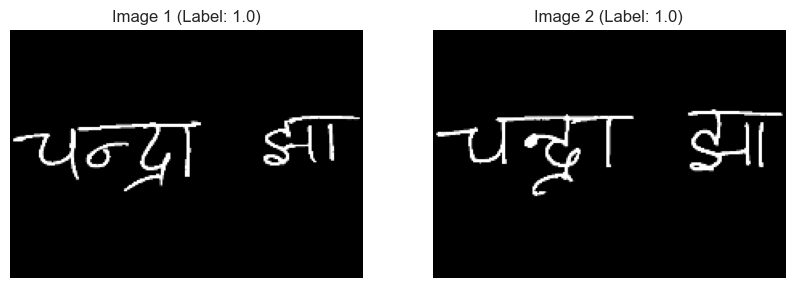

Example 2:
Image 1 shape: (155, 220)
Image 2 shape: (155, 220)
Label: 0.0
------------------------------


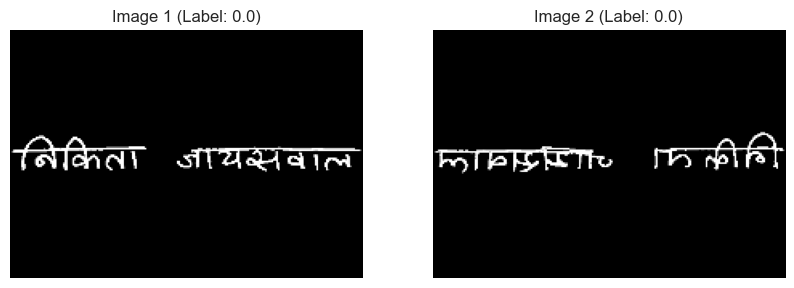

Example 3:
Image 1 shape: (155, 220)
Image 2 shape: (155, 220)
Label: 0.0
------------------------------


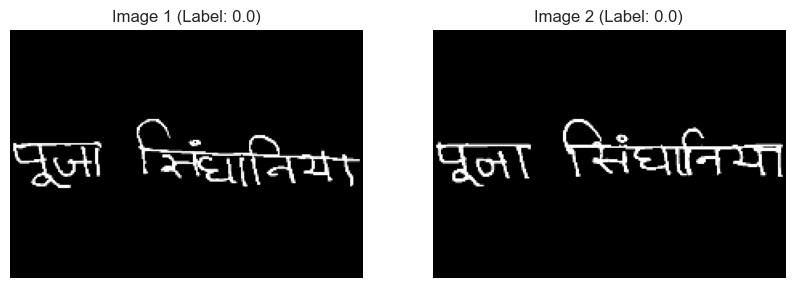

Example 4:
Image 1 shape: (155, 220)
Image 2 shape: (155, 220)
Label: 1.0
------------------------------


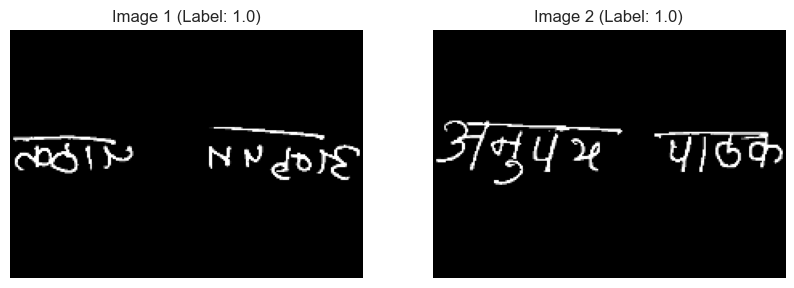

Example 5:
Image 1 shape: (155, 220)
Image 2 shape: (155, 220)
Label: 0.0
------------------------------


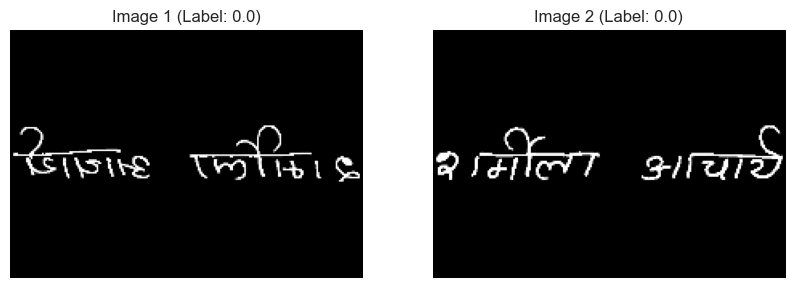

In [138]:
def print_and_visualize_dataset(dataset, num_samples=5):
    """
    Prints and visualizes the first `num_samples` examples from the dataset.
    Ensures the printed labels match the plotted labels.
    Args:
        dataset (tf.data.Dataset): The dataset to analyze.
        num_samples (int): Number of examples to print and visualize.
    """
    for idx, ((img1, img2), label) in enumerate(dataset.take(num_samples)):
        img1_single = img1[0].numpy().squeeze()
        img2_single = img2[0].numpy().squeeze()
        label_single = label[0].numpy()

        print(f"Example {idx + 1}:")
        print(f"Image 1 shape: {img1_single.shape}")
        print(f"Image 2 shape: {img2_single.shape}")
        print(f"Label: {label_single}")
        print("-" * 30)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img1_single, cmap="gray")
        plt.title(f"Image 1 (Label: {label_single})")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img2_single, cmap="gray")
        plt.title(f"Image 2 (Label: {label_single})")
        plt.axis("off")

        plt.show()

print_and_visualize_dataset(train_dataset, num_samples=5)

In [139]:
def euclidean_distance(vects):
    """
        Compute Euclidean Distance between two vectors
    """
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=-1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def contrastive_loss(y_true, y_pred):
    """
        Contrastive loss function
    """
    margin = 1.2
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))


def compute_accuracy(y_true, y_pred, threshold=0.5):
    """
        Compute accuracy based on a distance threshold
    """
    return K.mean(K.equal(y_true, K.cast(y_pred >= threshold, y_true.dtype)))



In [140]:
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)


def create_base_network(input_shape, alpha_value=0.3, l2_value=1e-4, dropout_value=0.5):
    """
        Base Siamese Network
    """

    model = Sequential()

    model.add(Conv2D(
        filters=32,
        kernel_size=(7, 7),
        input_shape=input_shape,
        name="block_1_conv2d"
    ))
    model.add(LeakyReLU(alpha=alpha_value, name="block_1_leaky_relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="block_1_pooling"))

    model.add(Conv2D(
        filters=64,
        kernel_size=(5, 5),
        name="block_2_conv2d"
    ))
    model.add(BatchNormalization(name="block_2_batch_norm"))
    model.add(LeakyReLU(alpha=alpha_value, name="block_2_leaky_relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="block_2_pooling"))

    model.add(Conv2D(
        filters=128,
        kernel_size=(3, 3),
        name="block_3_conv2d"
    ))
    model.add(BatchNormalization(name="block_3_batch_norm"))
    model.add(LeakyReLU(alpha=alpha_value, name="block_3_leaky_relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="block_3_pooling"))

    model.add(Conv2D(
        filters=256,
        kernel_size=(3, 3),
        name="block_4_conv2d"
    ))
    model.add(LeakyReLU(alpha=alpha_value, name="block_4_leaky_relu"))
    model.add(Dropout(0.2, name="block_4_dropout"))

    model.add(Conv2D(
        filters=512,
        kernel_size=(3, 3),
        name="block_5_conv2d"
    ))
    model.add(LeakyReLU(alpha=alpha_value, name="block_5_leaky_relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="block_5_pooling"))
    model.add(Dropout(0.2, name="block_5_dropout"))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(
        units=512,
        kernel_regularizer=l2(l2_value),
        activation="relu",
        name="dense1"
    ))
    model.add(Dropout(dropout_value, name="dense1_dropout"))

    model.add(Dense(
        units=128,
        kernel_regularizer=l2(l2_value),
        activation="linear",
        name="dense2"
    ))

    return model

In [141]:
base_network = create_base_network(INPUT_SHAPE)

base_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block_1_conv2d (Conv2D)     (None, 149, 214, 32)      1600      
                                                                 
 block_1_leaky_relu (LeakyRe  (None, 149, 214, 32)     0         
 LU)                                                             
                                                                 
 block_1_pooling (MaxPooling  (None, 74, 107, 32)      0         
 2D)                                                             
                                                                 
 block_2_conv2d (Conv2D)     (None, 70, 103, 64)       51264     
                                                                 
 block_2_batch_norm (BatchNo  (None, 70, 103, 64)      256       
 rmalization)                                                    
                                                        

Extracting embeddings...
0 pairs processed...
10 pairs processed...
20 pairs processed...
30 pairs processed...
40 pairs processed...
Extracting embeddings...
0 pairs processed...
10 pairs processed...
20 pairs processed...
30 pairs processed...
40 pairs processed...
Extracting embeddings...
0 pairs processed...
10 pairs processed...
20 pairs processed...
30 pairs processed...
40 pairs processed...


C:\Users\boros\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


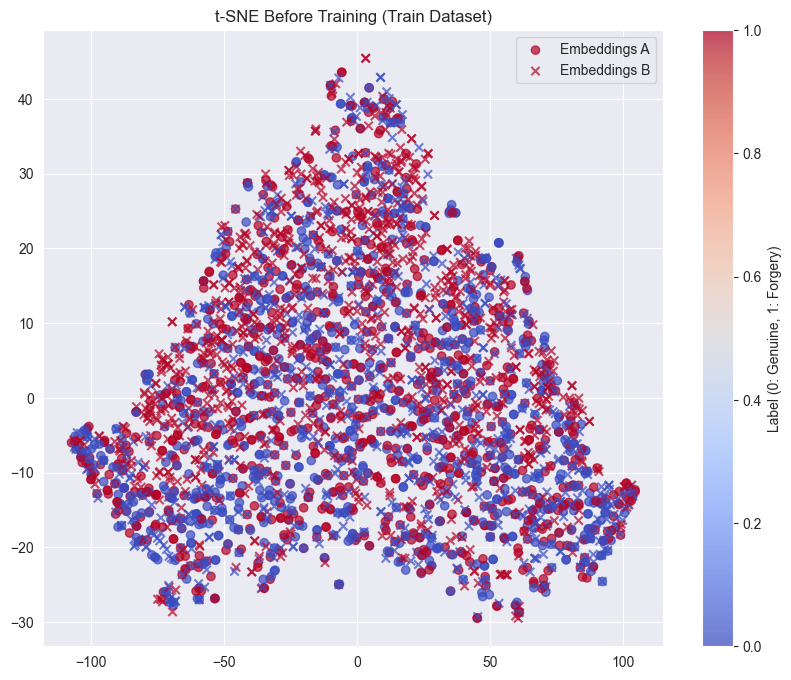

C:\Users\boros\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


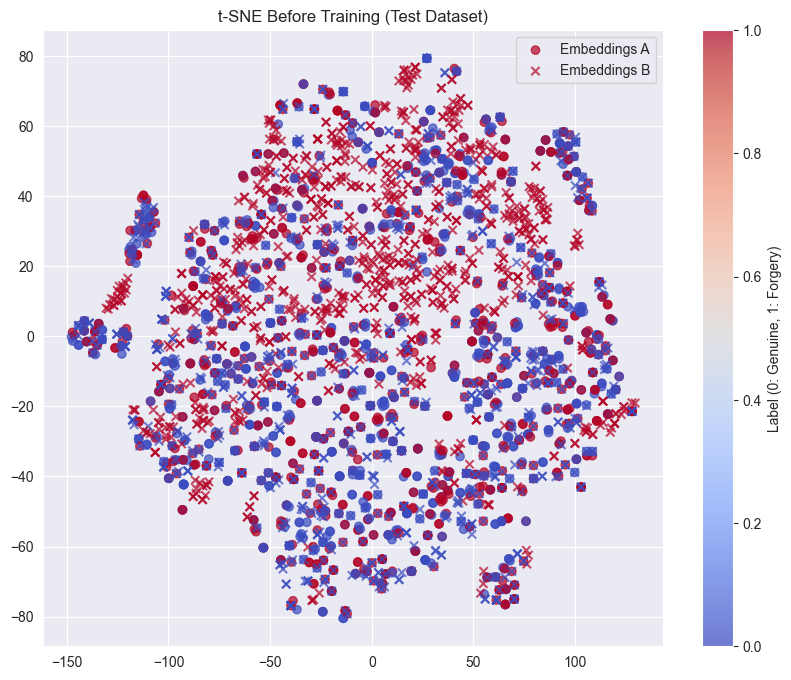

C:\Users\boros\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


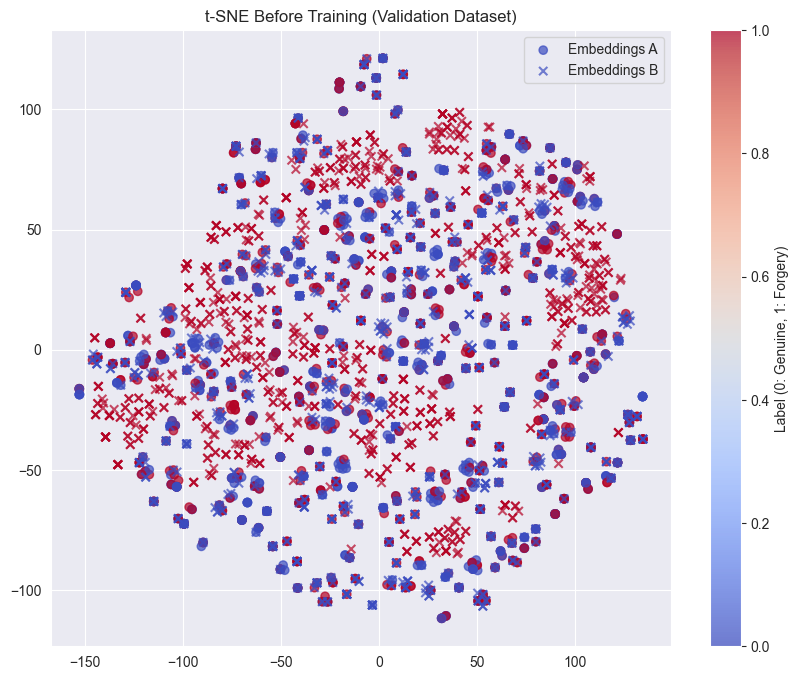

In [142]:
def extract_embeddings(base_network, dataset):
    embeddings_a = []
    embeddings_b = []
    labels = []

    print("Extracting embeddings...")
    for idx, ((input_a, input_b), label) in enumerate(dataset):
        embedding_a = base_network.predict(input_a, verbose=0)
        embedding_b = base_network.predict(input_b, verbose=0)

        embeddings_a.append(embedding_a)
        embeddings_b.append(embedding_b)
        labels.append(label.numpy())

        if idx % 10 == 0:
            print(f"{idx} pairs processed...")

    embeddings_a = np.vstack(embeddings_a)
    embeddings_b = np.vstack(embeddings_b)
    labels = np.hstack(labels)

    return embeddings_a, embeddings_b, labels


def plot_tsne(embeddings_a, embeddings_b, labels, title):
    combined_embeddings = np.vstack([embeddings_a, embeddings_b])
    reduced_embeddings = TSNE(n_components=2, perplexity=30, n_iter=1000).fit_transform(combined_embeddings)

    num_samples = len(embeddings_a)
    reduced_a = reduced_embeddings[:num_samples]
    reduced_b = reduced_embeddings[num_samples:]

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_a[:, 0], reduced_a[:, 1], c=labels, cmap='coolwarm', alpha=0.7, label="Embeddings A")
    plt.scatter(reduced_b[:, 0], reduced_b[:, 1], c=labels, cmap='coolwarm', marker='x', alpha=0.7,
                label="Embeddings B")
    plt.colorbar(label='Label (0: Genuine, 1: Forgery)')
    plt.title(title)
    plt.legend()
    plt.show()


samples = 50

base_network_untrained = Model(inputs=base_network.input, outputs=base_network.output)
train_embeddings_a_before, train_embeddings_b_before, train_labels_tsne = extract_embeddings(base_network_untrained,
                                                                                             train_dataset.take(
                                                                                                 samples))
test_embeddings_a_before, test_embeddings_b_before, test_labels_tsne = extract_embeddings(base_network_untrained,
                                                                                          test_dataset.take(samples))
validation_embeddings_a_before, validation_embeddings_b_before, validation_labels_tsne = extract_embeddings(
    base_network_untrained, validation_dataset.take(samples))

plot_tsne(train_embeddings_a_before, train_embeddings_b_before, train_labels_tsne,"t-SNE Before Training (Train Dataset)")
plot_tsne(test_embeddings_a_before, test_embeddings_b_before, test_labels_tsne, "t-SNE Before Training (Test Dataset)")
plot_tsne(validation_embeddings_a_before, validation_embeddings_b_before, validation_labels_tsne,"t-SNE Before Training (Validation Dataset)")


In [146]:
optimizers = {
    "RMSprop": RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-07),
    "Adam": Adam(learning_rate=1e-4)
}
input_a = Input(shape=INPUT_SHAPE)
input_b = Input(shape=INPUT_SHAPE)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

siamese_model = Model(inputs=[input_a, input_b], outputs=distance)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1, min_delta=0),
    ModelCheckpoint('best_model_weight_hindi.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

siamese_model.compile(optimizer=optimizers['RMSprop'], loss=contrastive_loss, metrics=[compute_accuracy])

In [147]:
history = siamese_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
1984/1984 [==============================] - ETA: 0s - loss: 0.1871 - compute_accuracy: 0.8260
Epoch 1: val_loss improved from inf to 0.26073, saving model to best_model_weight_hindi.h5
1984/1984 [==============================] - 783s 394ms/step - loss: 0.1871 - compute_accuracy: 0.8260 - val_loss: 0.2607 - val_compute_accuracy: 0.7776 - lr: 1.0000e-04
Epoch 2/10
1984/1984 [==============================] - ETA: 0s - loss: 0.0847 - compute_accuracy: 0.9367
Epoch 2: val_loss improved from 0.26073 to 0.20356, saving model to best_model_weight_hindi.h5
1984/1984 [==============================] - 813s 410ms/step - loss: 0.0847 - compute_accuracy: 0.9367 - val_loss: 0.2036 - val_compute_accuracy: 0.7968 - lr: 1.0000e-04
Epoch 3/10
1984/1984 [==============================] - ETA: 0s - loss: 0.0473 - compute_accuracy: 0.9712
Epoch 3: val_loss improved from 0.20356 to 0.15957, saving model to best_model_weight_hindi.h5
1984/1984 [==============================] - 810s 408ms/step 

In [148]:
siamese_model.load_weights('best_model_weight_hindi.h5')
best_accuracy = siamese_model.evaluate(test_dataset)
print(f"Best model accuracy: {best_accuracy}")

siamese_model.save("best_model_hindi.h5")

552/552 [==============================] - 156s 282ms/step - loss: 0.1399 - compute_accuracy: 0.8712
Best model accuracy: [0.1399499475955963, 0.8712069988250732]


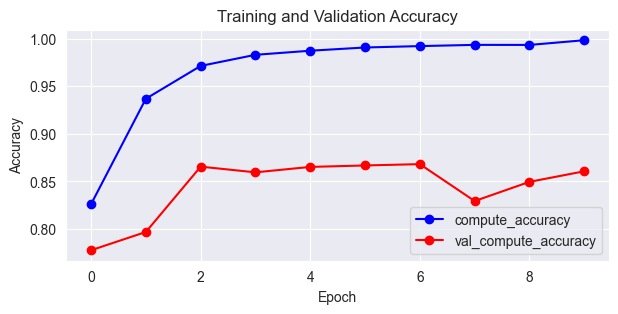

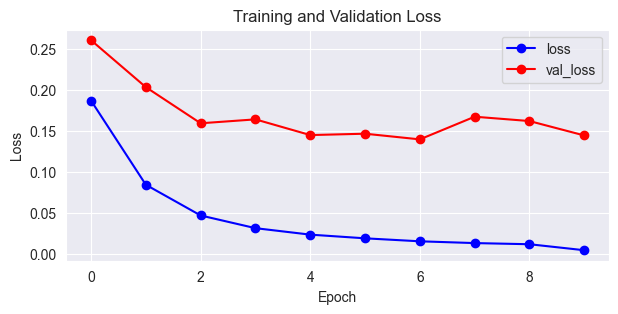

In [149]:
def plot_accuracy_history(history, metrics_dict):
    """
    Plot the training and validation metric history.
    
    Args:
        history (History): Keras History object.
        metrics_dict (dict): A dictionary of metric names and colors.
                             Example: {'accuracy': 'blue', 'val_accuracy': 'red'}
    """
    plt.figure(figsize=(7, 3))

    for metric, color in metrics_dict.items():
        plt.plot(history.history[metric], label=f'{metric}', color=color, marker='o')

    is_accuracy = 'accuracy' in list(metrics_dict.keys())[0].lower()
    plt.title('Training and Validation Accuracy' if is_accuracy else 'Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy' if is_accuracy else 'Loss')

    plt.legend()
    plt.grid(True)
    plt.show()


accuracy_dict = {
    'compute_accuracy': 'blue',
    'val_compute_accuracy': 'red'
}
loss_dict = {
    'loss': 'blue',
    'val_loss': 'red'
}

plot_accuracy_history(history, accuracy_dict)
plot_accuracy_history(history, loss_dict)

In [150]:
def compute_distances(model, dataset, steps):
    """
    Compute distances for a batch of validation pairs.

    Parameters:
        model: Trained Siamese model.
        dataset: Validation dataset created with tf.data.Dataset.
        steps: Number of steps to process (usually len(validation_pairs) // batch_size).

    Returns:
        positive_distances: Distances for positive pairs (label = 0).
        negative_distances: Distances for negative pairs (label = 1).
    """
    positive_distances = []
    negative_distances = []

    for idx, (inputs, labels) in enumerate(dataset.take(steps)):
        predictions = model.predict(inputs, verbose=1)

        labels = tf.cast(labels, tf.int32).numpy()
        predictions = predictions.flatten()

        positive_distances.extend(predictions[labels == 0])  # Positive pairs (label = 0)
        negative_distances.extend(predictions[labels == 1])  # Negative pairs (label = 1)

    return np.array(positive_distances), np.array(negative_distances)

positive_distances, negative_distances = compute_distances(siamese_model, validation_dataset, steps=len(val_pairs) // BATCH_SIZE)

1/1 [==============================] - 0s 26ms/step


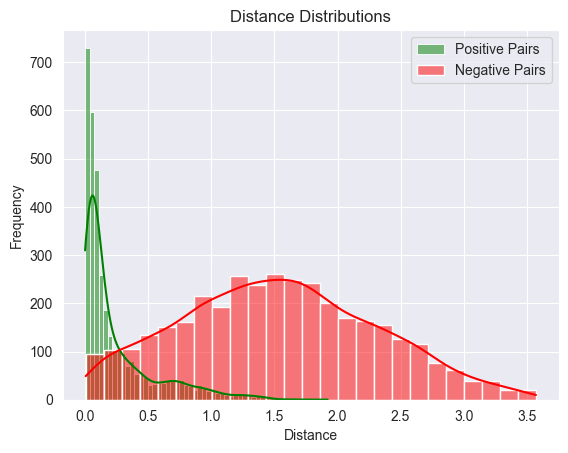

In [151]:
sns.histplot(positive_distances, label="Positive Pairs", color="green", kde=True)
sns.histplot(negative_distances, label="Negative Pairs", color="red", kde=True)
plt.legend()
plt.title("Distance Distributions")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

In [152]:
distances = siamese_model.predict(test_dataset, verbose=1)
true_labels = np.concatenate([labels.numpy() for _, labels in test_dataset])

threshold = 0.5
predicted_labels = (distances > threshold).astype(int)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


552/552 [==============================] - 147s 267ms/step
Accuracy: 0.8712069746376812, Precision: 0.8649671601914728, Recall: 0.8797554347826086, F1-Score: 0.8722986247544204


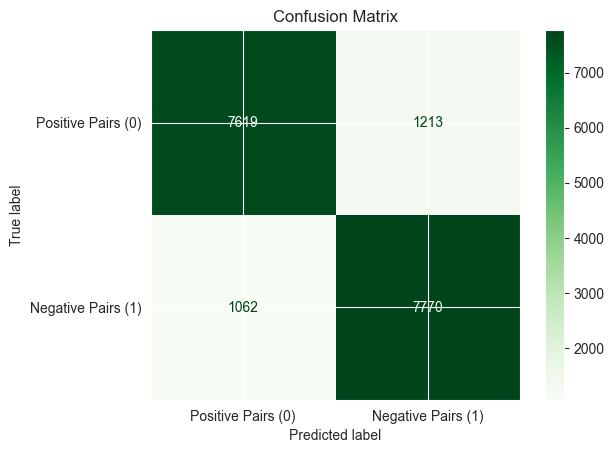

In [153]:
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive Pairs (0)", "Negative Pairs (1)"])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.show()


Extracting embeddings...
0 pairs processed...
10 pairs processed...
20 pairs processed...
30 pairs processed...
40 pairs processed...
Extracting embeddings...
0 pairs processed...
10 pairs processed...
20 pairs processed...
30 pairs processed...
40 pairs processed...
Extracting embeddings...
0 pairs processed...
10 pairs processed...
20 pairs processed...
30 pairs processed...
40 pairs processed...


C:\Users\boros\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


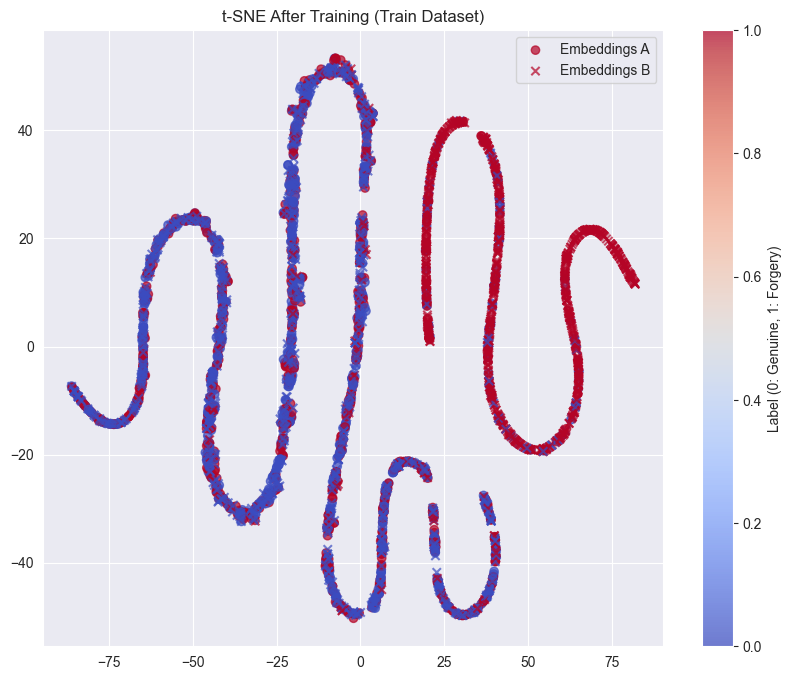

C:\Users\boros\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


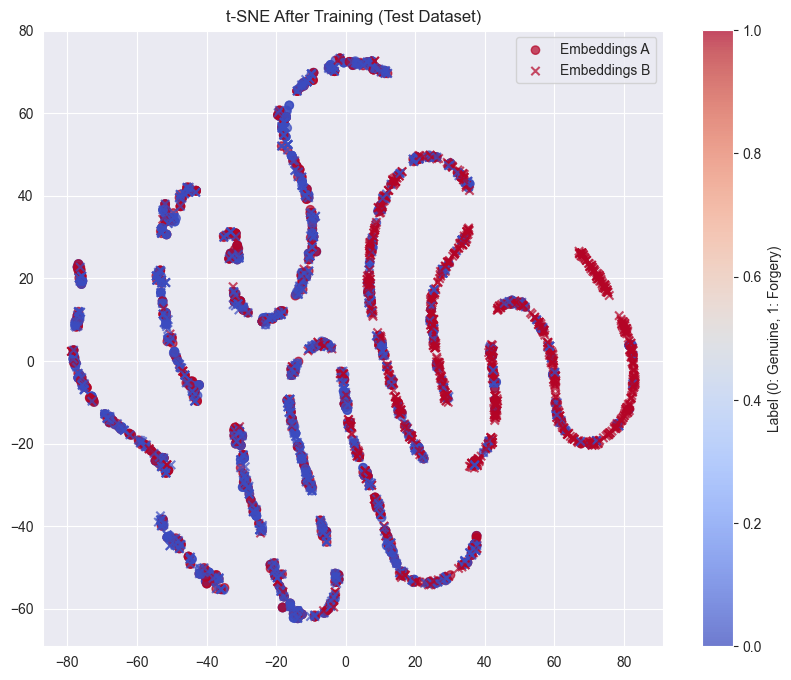

C:\Users\boros\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


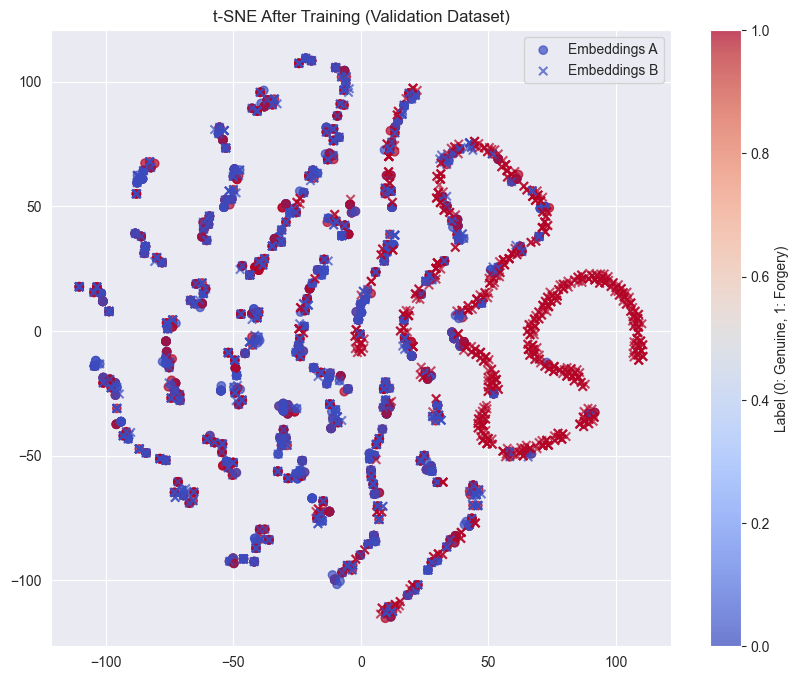

In [154]:
train_embeddings_a_after, train_embeddings_b_after, train_labels_tsne = extract_embeddings(base_network,
                                                                                           train_dataset.take(samples))
test_embeddings_a_after, test_embeddings_b_after, test_labels_tsne = extract_embeddings(base_network,
                                                                                        test_dataset.take(samples))
validation_embeddings_a_after, validation_embeddings_b_after, validation_labels_tsne = extract_embeddings(base_network,
                                                                                                          validation_dataset.take(
                                                                                                              samples))

plot_tsne(train_embeddings_a_after, train_embeddings_b_after, train_labels_tsne, "t-SNE After Training (Train Dataset)")
plot_tsne(test_embeddings_a_after, test_embeddings_b_after, test_labels_tsne, "t-SNE After Training (Test Dataset)")
plot_tsne(validation_embeddings_a_after, validation_embeddings_b_after, validation_labels_tsne,
          "t-SNE After Training (Validation Dataset)")

1/1 [==============================] - 0s 121ms/step


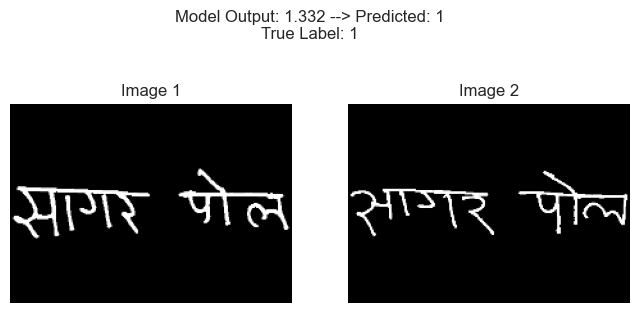

1/1 [==============================] - 0s 31ms/step


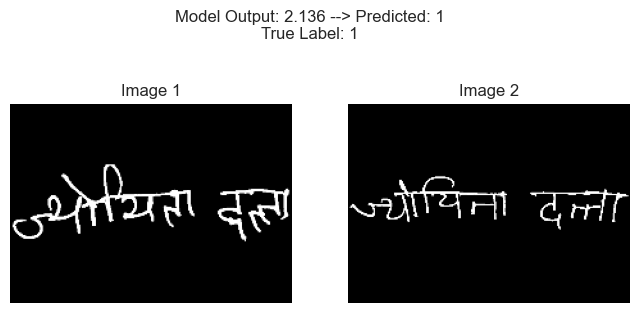

1/1 [==============================] - 0s 24ms/step


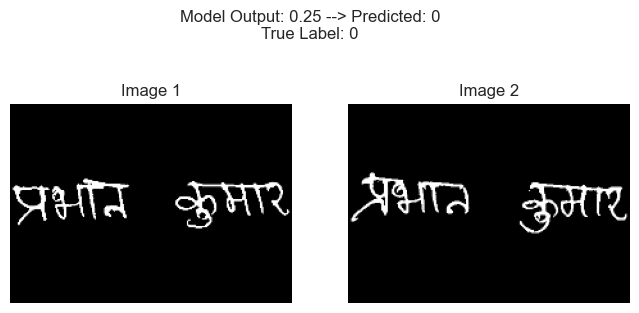

1/1 [==============================] - 0s 25ms/step


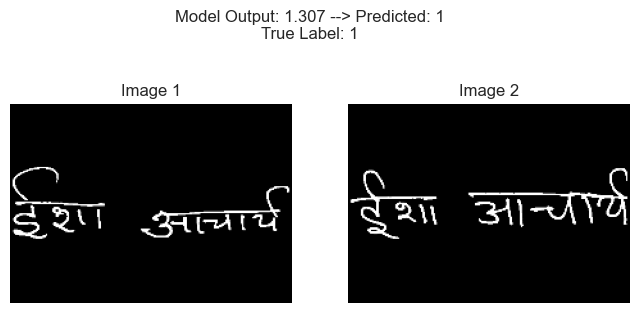

1/1 [==============================] - 0s 24ms/step


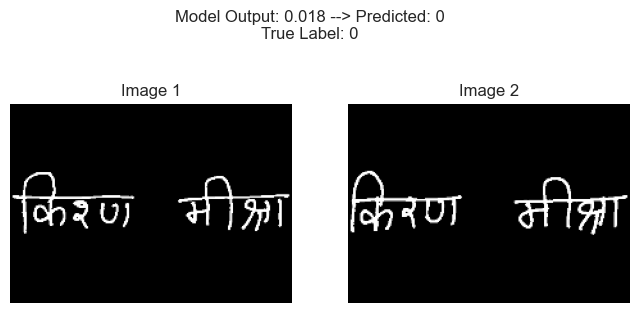

1/1 [==============================] - 0s 27ms/step


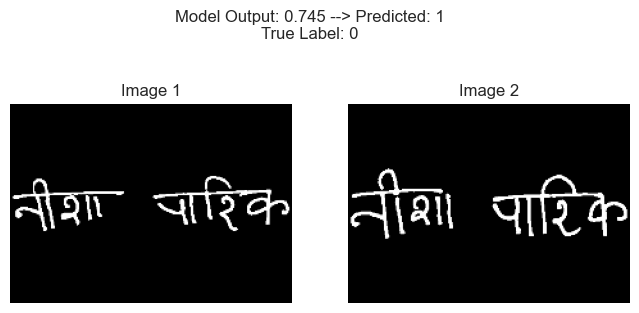

1/1 [==============================] - 0s 27ms/step


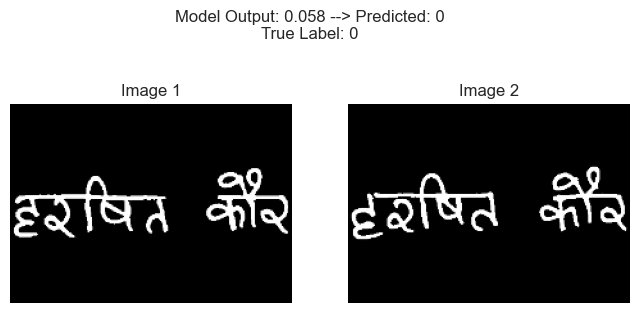

1/1 [==============================] - 0s 33ms/step


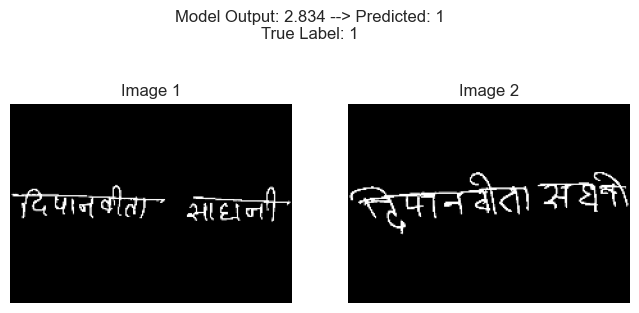

1/1 [==============================] - 0s 23ms/step


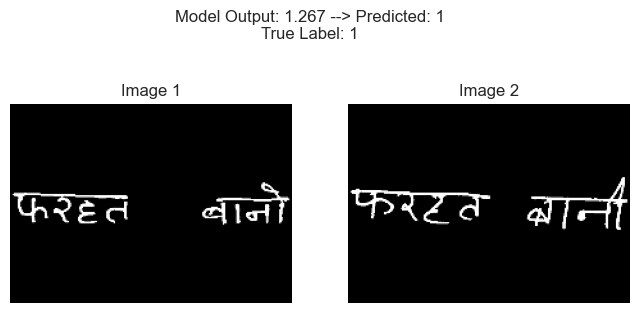

1/1 [==============================] - 0s 33ms/step


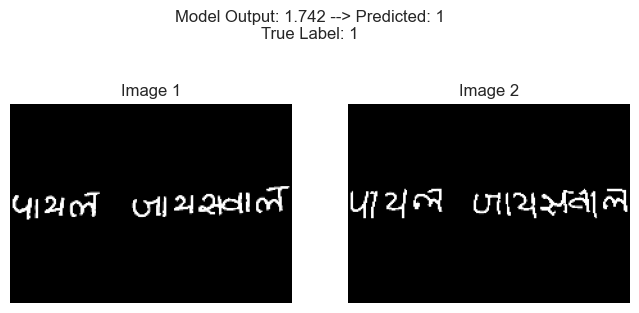

1/1 [==============================] - 0s 28ms/step


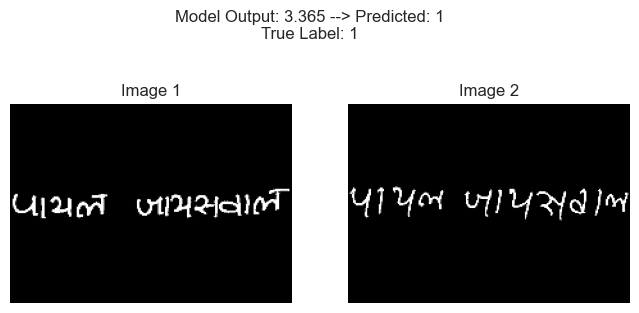

1/1 [==============================] - 0s 30ms/step


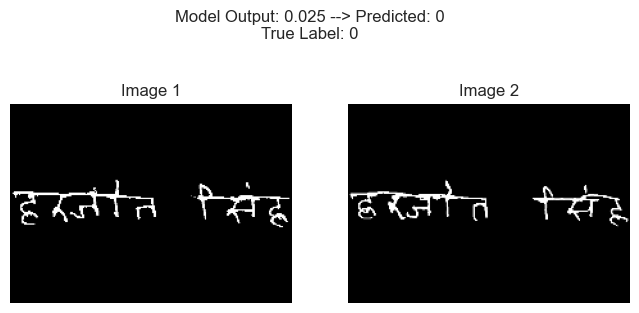

1/1 [==============================] - 0s 24ms/step


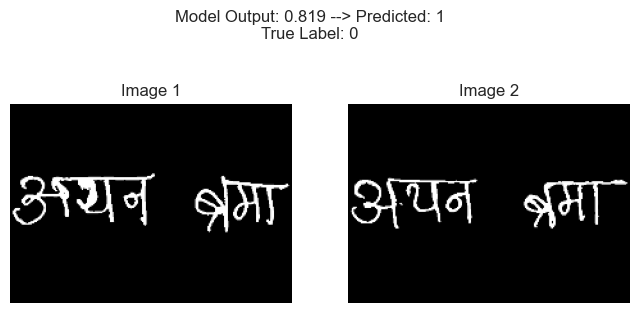

1/1 [==============================] - 0s 24ms/step


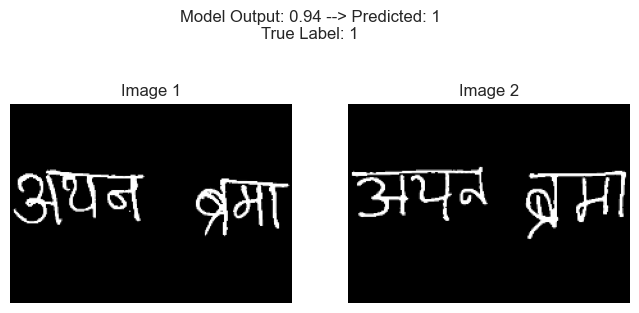

1/1 [==============================] - 0s 25ms/step


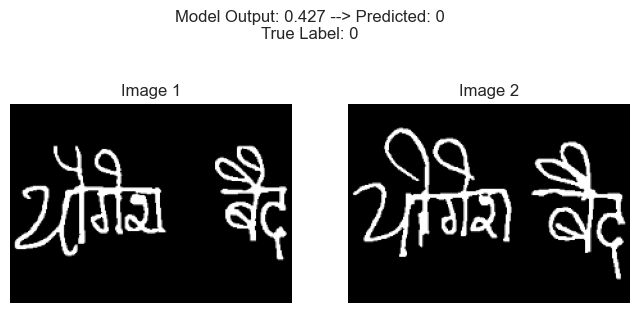

1/1 [==============================] - 0s 28ms/step


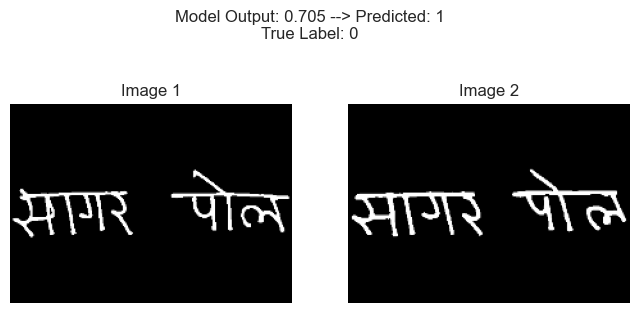

1/1 [==============================] - 0s 25ms/step


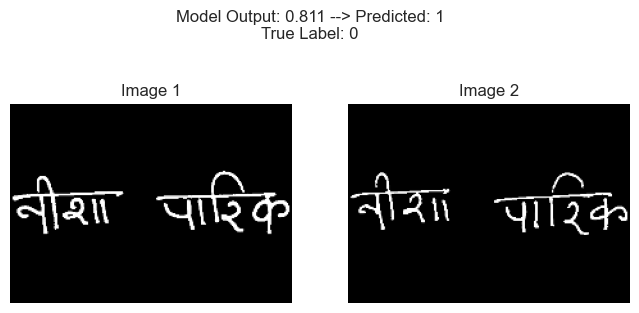

1/1 [==============================] - 0s 23ms/step


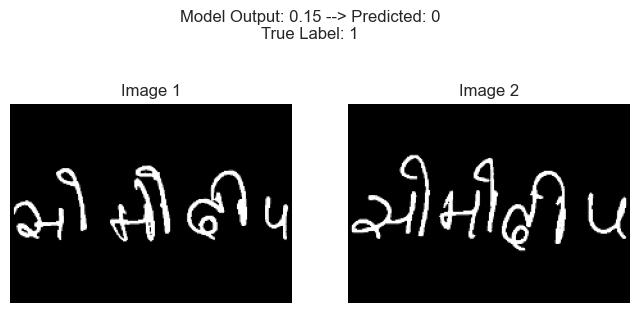

1/1 [==============================] - 0s 27ms/step


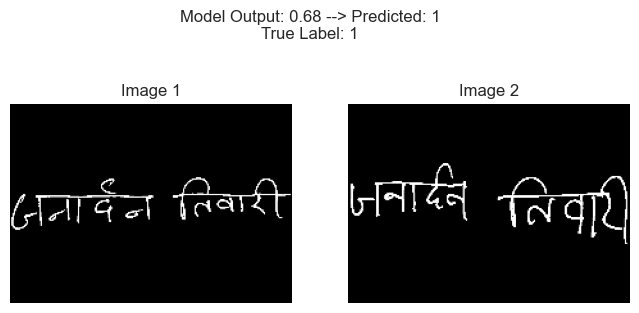

1/1 [==============================] - 0s 24ms/step


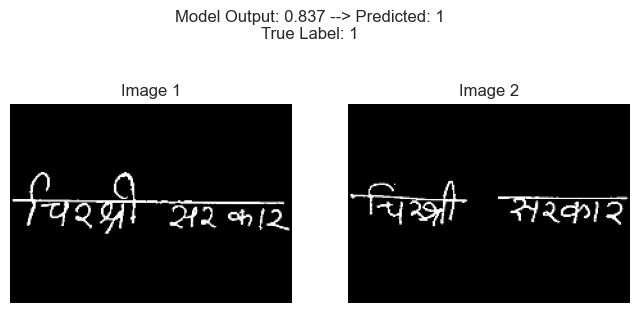

1/1 [==============================] - 0s 31ms/step


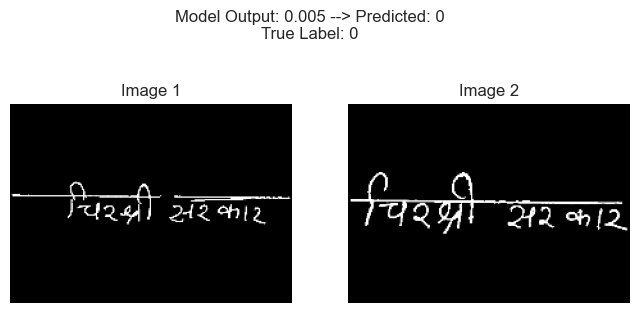

1/1 [==============================] - 0s 32ms/step


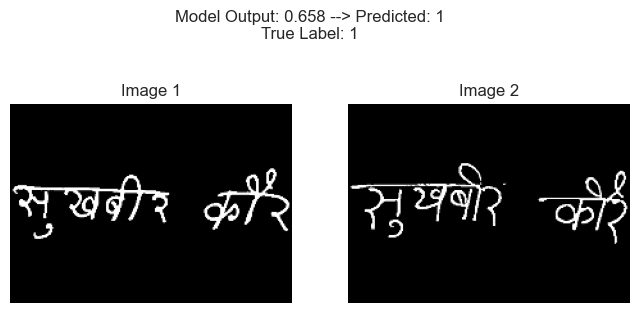

1/1 [==============================] - 0s 31ms/step


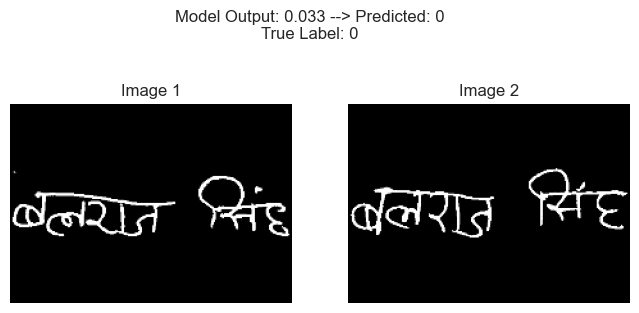

1/1 [==============================] - 0s 29ms/step


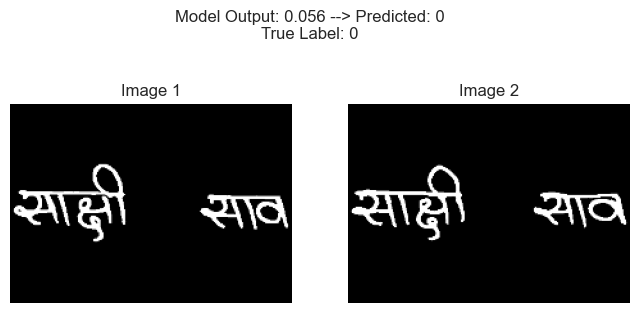

1/1 [==============================] - 0s 26ms/step


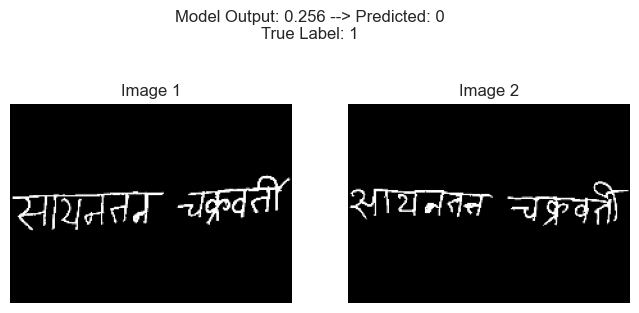

1/1 [==============================] - 0s 23ms/step


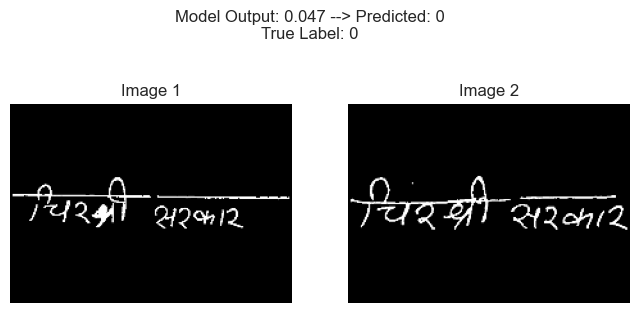

1/1 [==============================] - 0s 27ms/step


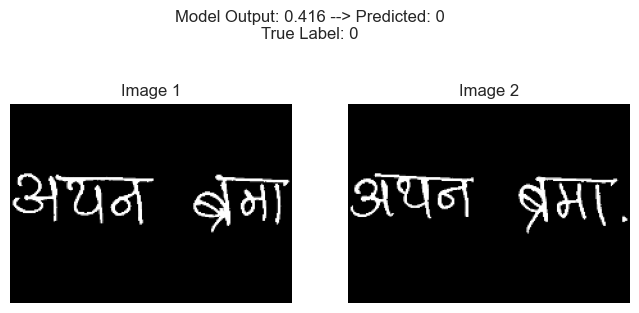

1/1 [==============================] - 0s 32ms/step


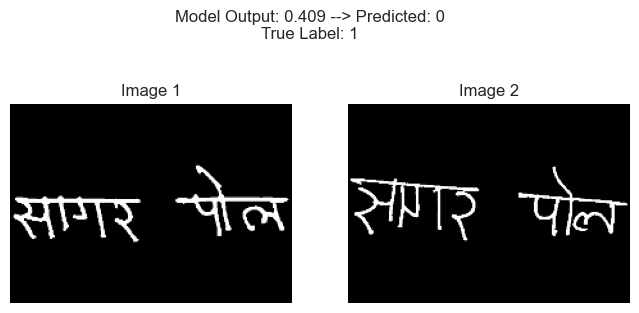

1/1 [==============================] - 0s 26ms/step


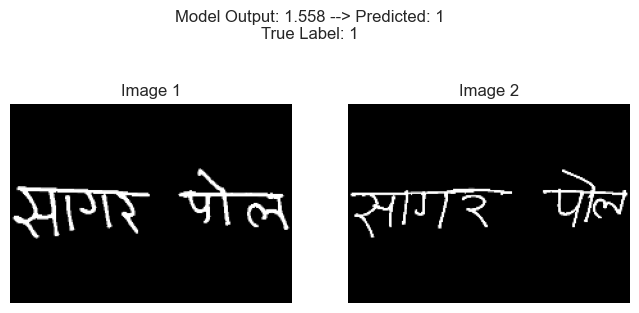

1/1 [==============================] - 0s 26ms/step


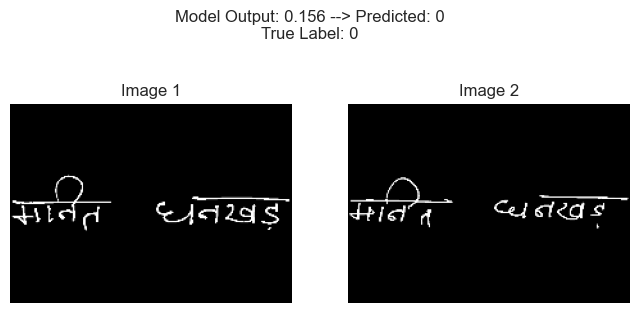

1/1 [==============================] - 0s 27ms/step


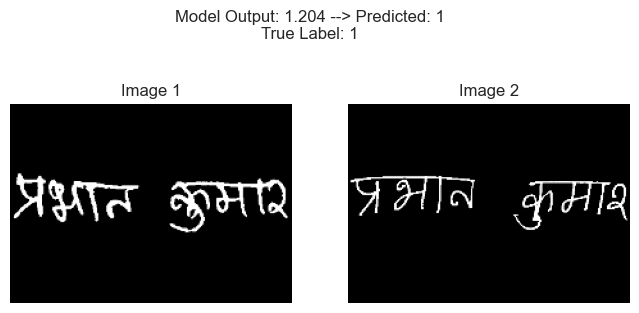

1/1 [==============================] - 0s 24ms/step


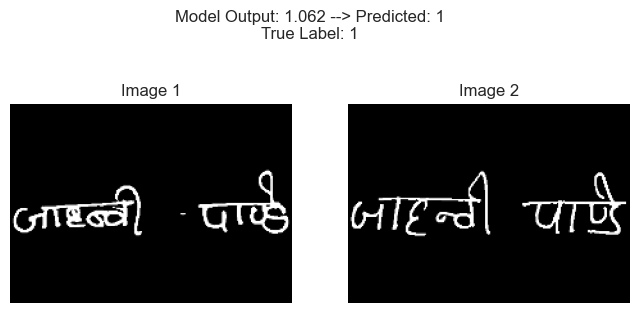

1/1 [==============================] - 0s 27ms/step


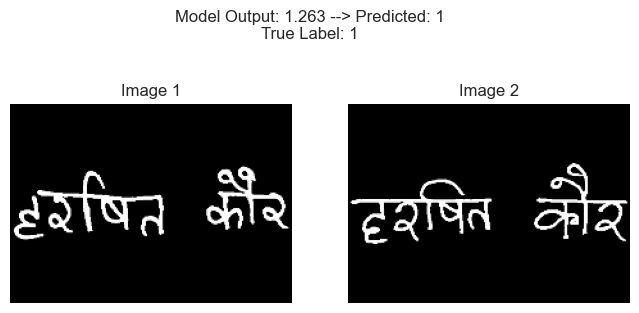

1/1 [==============================] - 0s 27ms/step


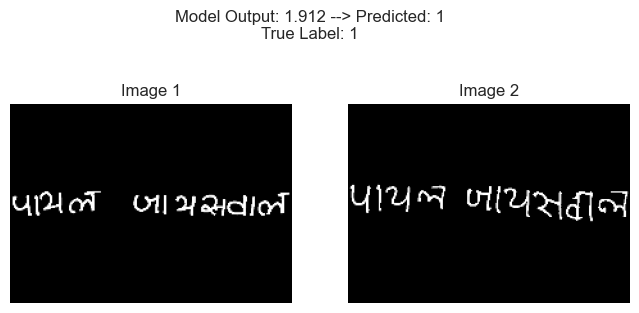

1/1 [==============================] - 0s 30ms/step


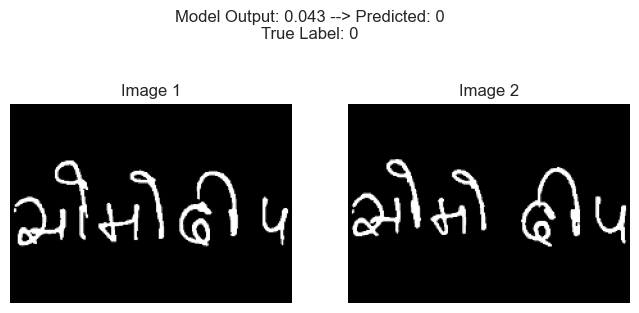

1/1 [==============================] - 0s 23ms/step


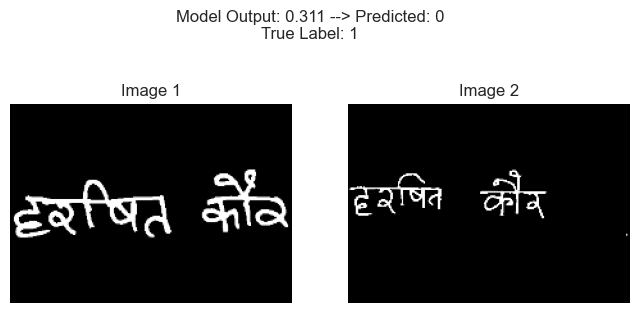

1/1 [==============================] - 0s 31ms/step


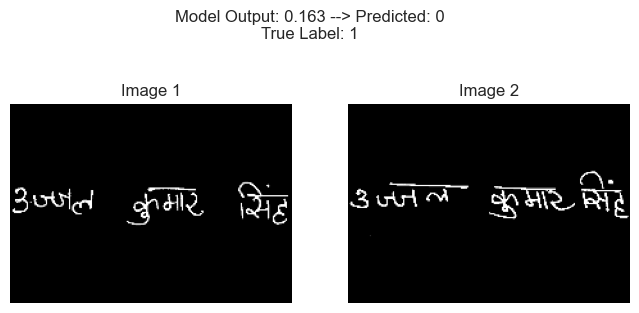

1/1 [==============================] - 0s 24ms/step


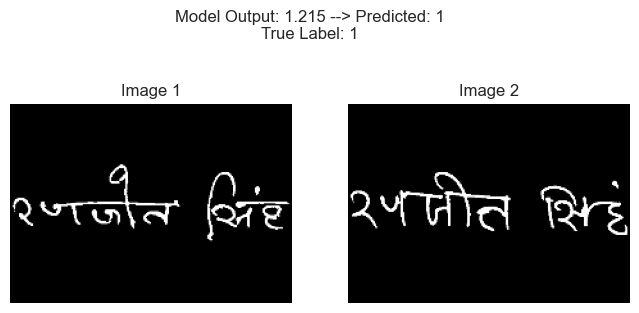

1/1 [==============================] - 0s 23ms/step


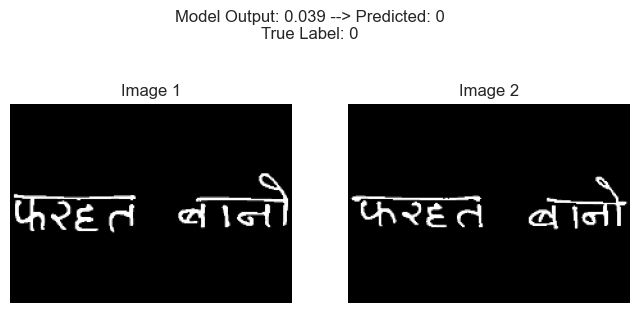

1/1 [==============================] - 0s 24ms/step


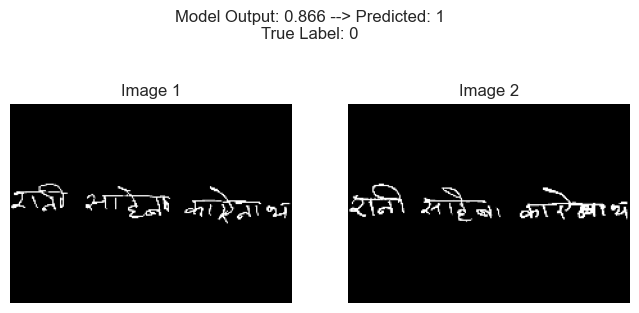

1/1 [==============================] - 0s 26ms/step


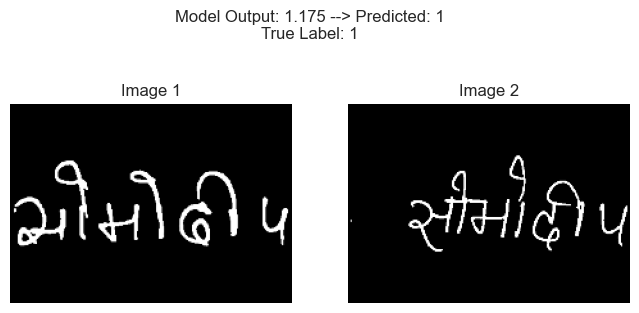

1/1 [==============================] - 0s 36ms/step


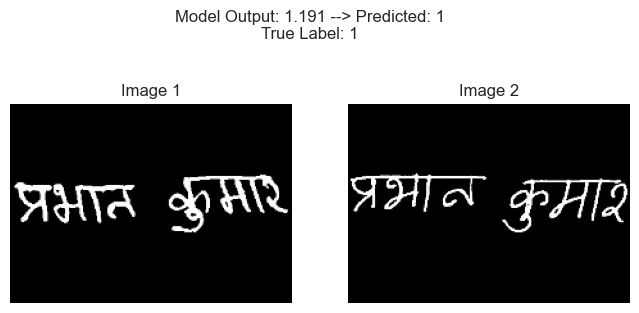

1/1 [==============================] - 0s 22ms/step


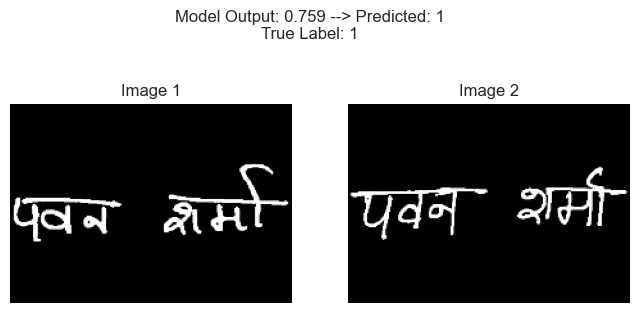

1/1 [==============================] - 0s 24ms/step


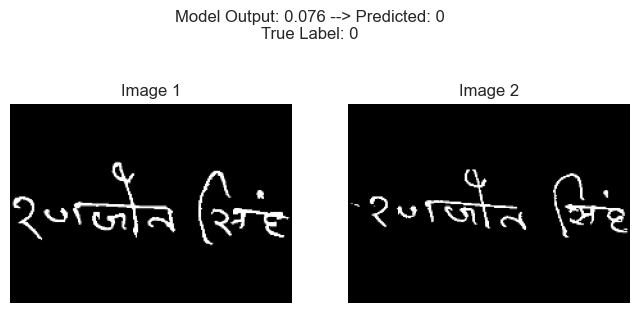

1/1 [==============================] - 0s 26ms/step


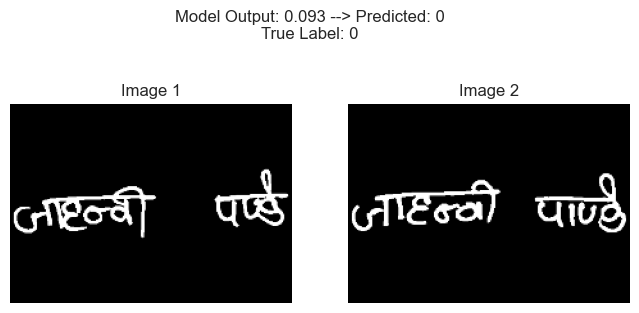

1/1 [==============================] - 0s 33ms/step


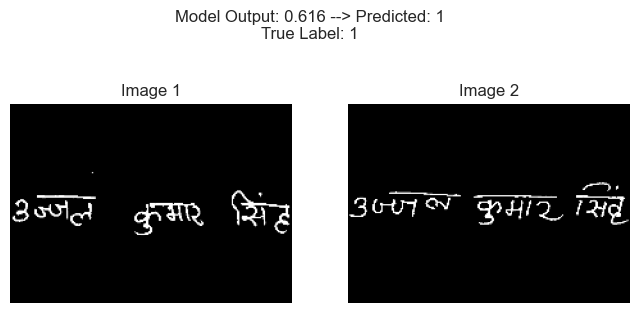

1/1 [==============================] - 0s 32ms/step


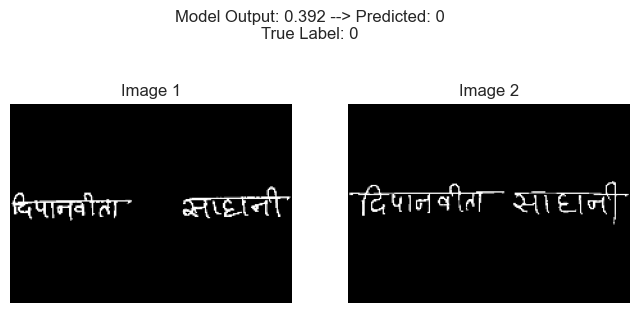

1/1 [==============================] - 0s 24ms/step


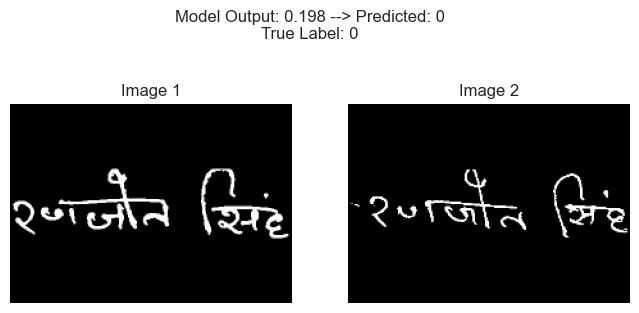

1/1 [==============================] - 0s 39ms/step


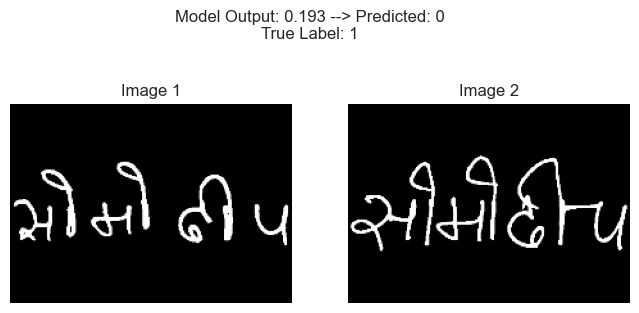

1/1 [==============================] - 0s 32ms/step


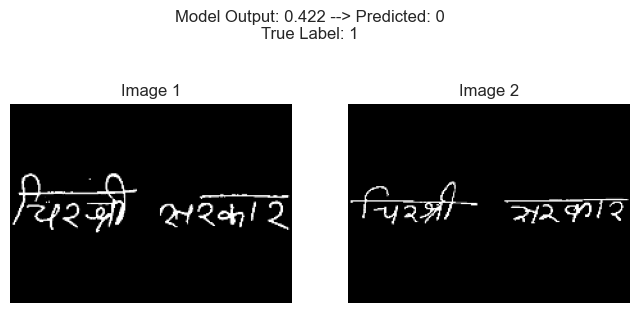

1/1 [==============================] - 0s 26ms/step


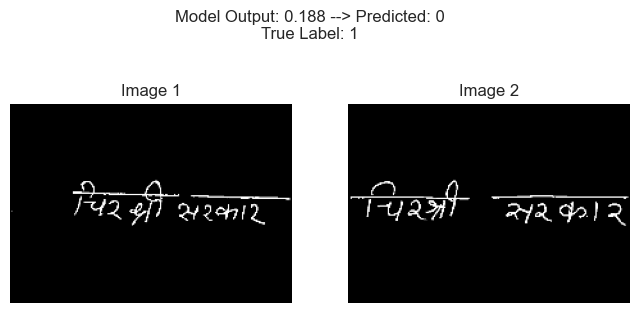

1/1 [==============================] - 0s 26ms/step


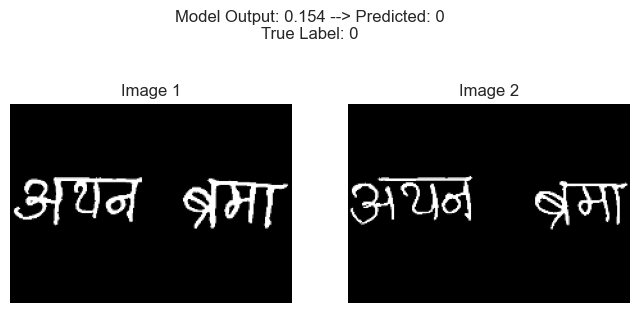

1/1 [==============================] - 0s 30ms/step


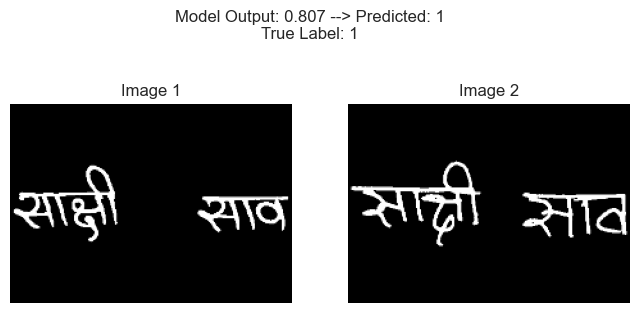

1/1 [==============================] - 0s 23ms/step


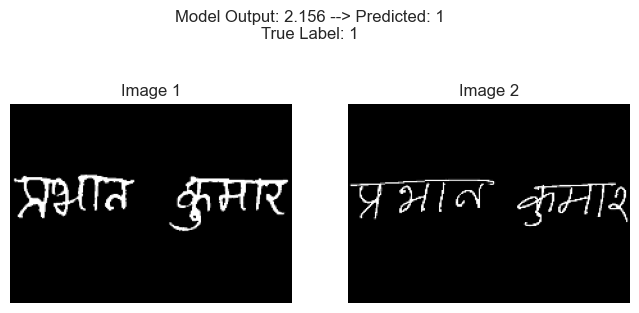

1/1 [==============================] - 0s 24ms/step


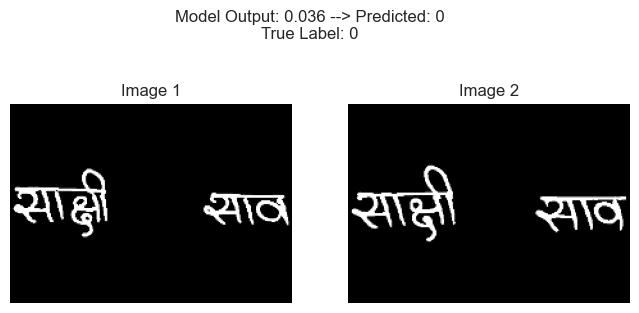

1/1 [==============================] - 0s 27ms/step


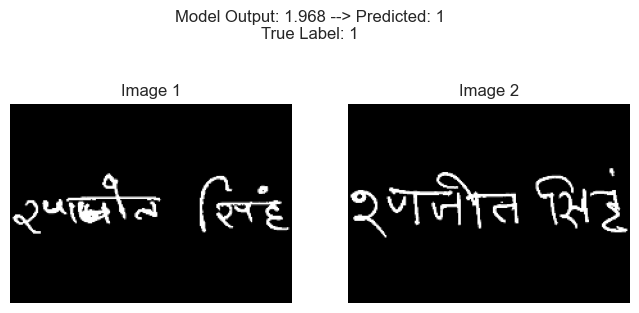

1/1 [==============================] - 0s 26ms/step


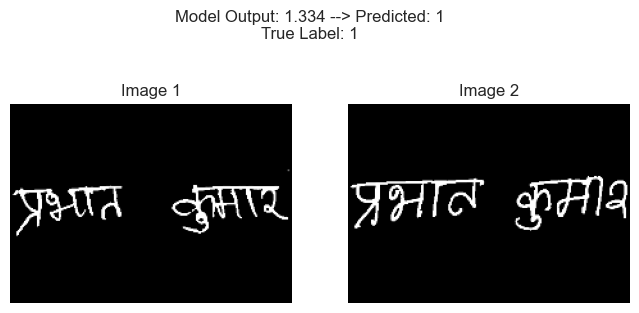

1/1 [==============================] - 0s 26ms/step


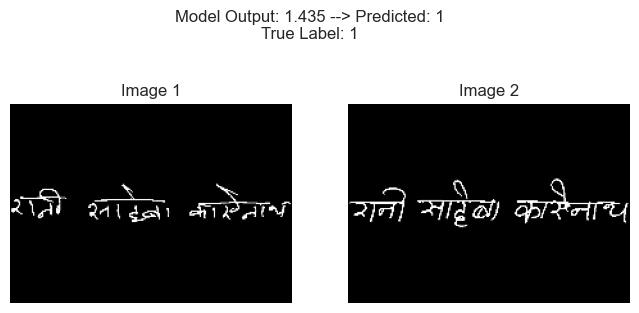

1/1 [==============================] - 0s 29ms/step


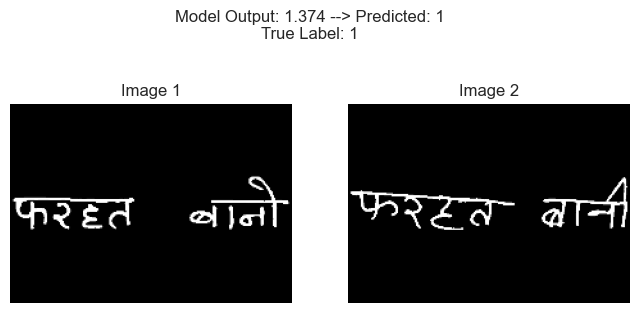

1/1 [==============================] - 0s 24ms/step


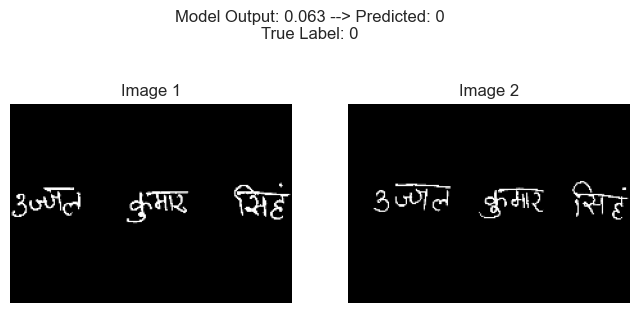

1/1 [==============================] - 0s 25ms/step


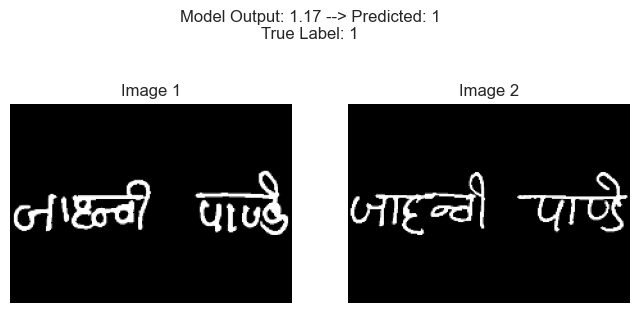

1/1 [==============================] - 0s 27ms/step


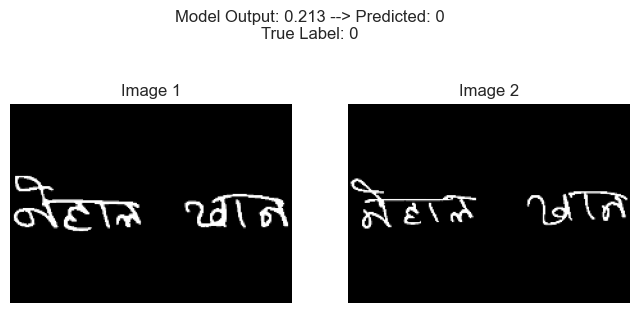

1/1 [==============================] - 0s 28ms/step


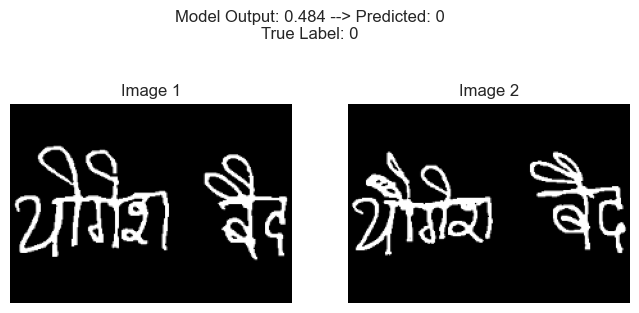

1/1 [==============================] - 0s 25ms/step


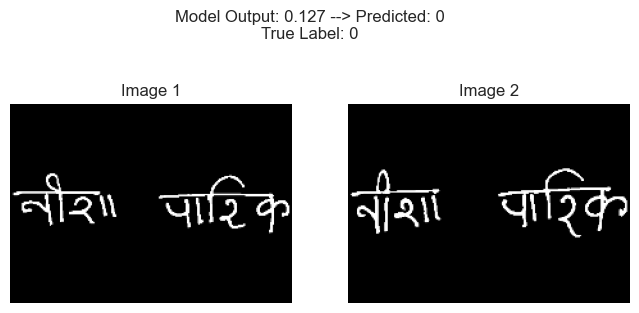

1/1 [==============================] - 0s 22ms/step


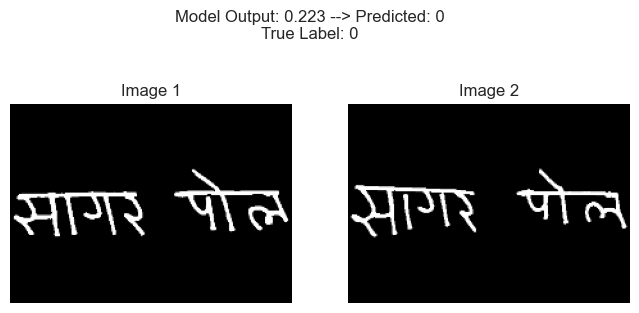

1/1 [==============================] - 0s 22ms/step


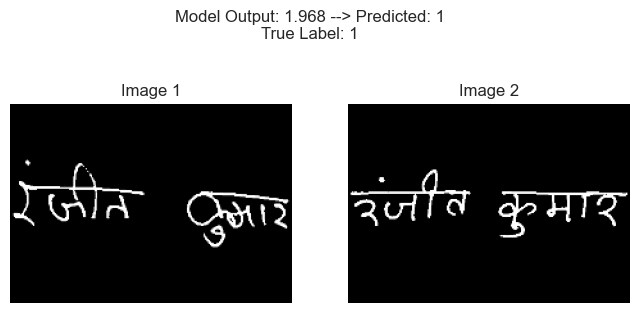

1/1 [==============================] - 0s 25ms/step


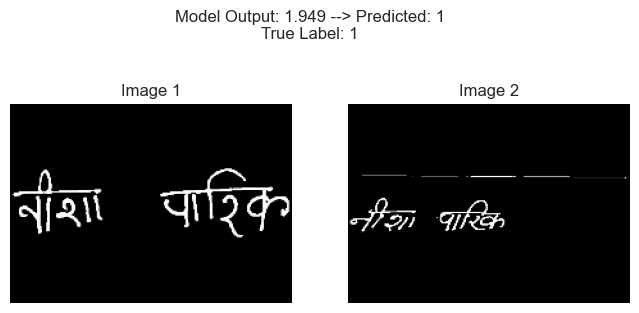

1/1 [==============================] - 0s 27ms/step


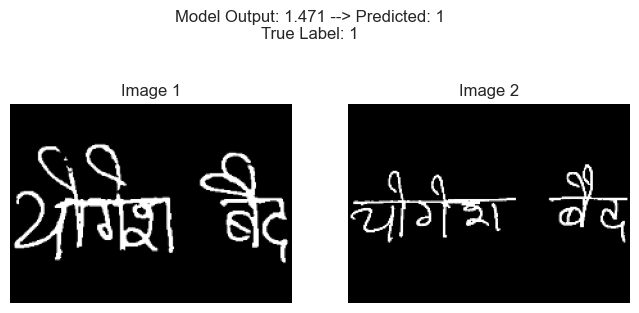

1/1 [==============================] - 0s 24ms/step


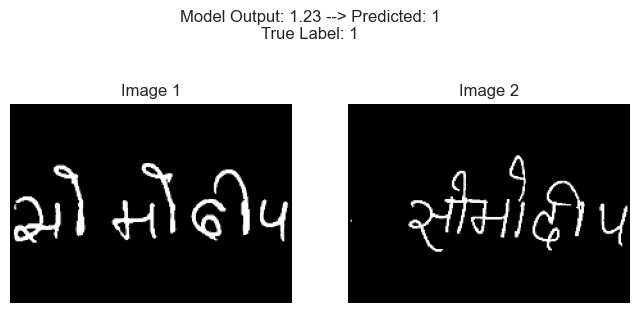

1/1 [==============================] - 0s 32ms/step


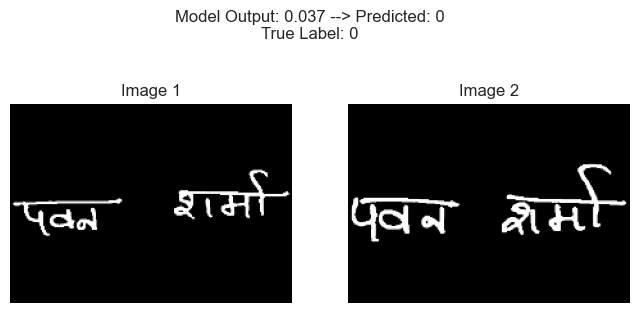

1/1 [==============================] - 0s 24ms/step


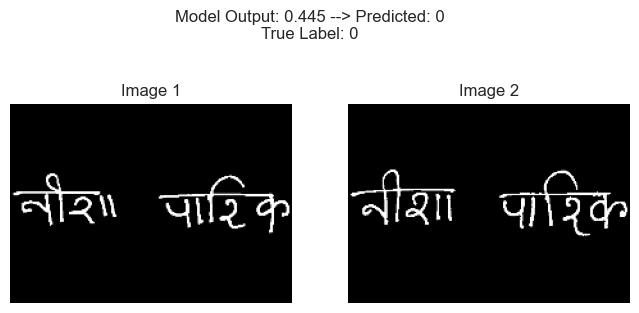

1/1 [==============================] - 0s 33ms/step


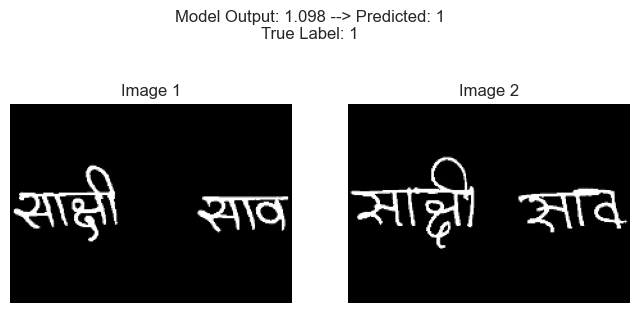

1/1 [==============================] - 0s 27ms/step


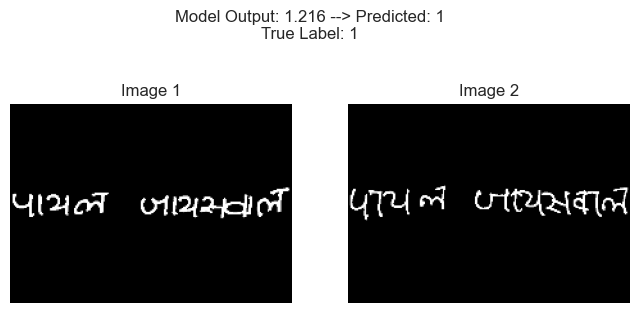

1/1 [==============================] - 0s 33ms/step


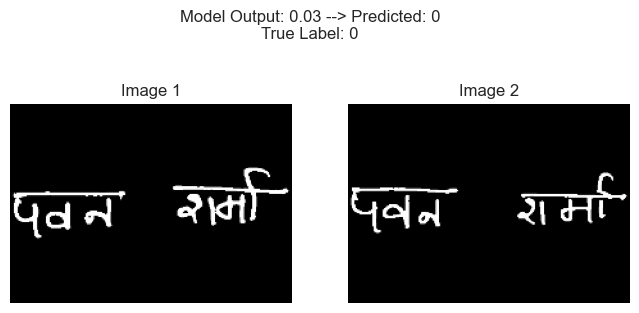

1/1 [==============================] - 0s 26ms/step


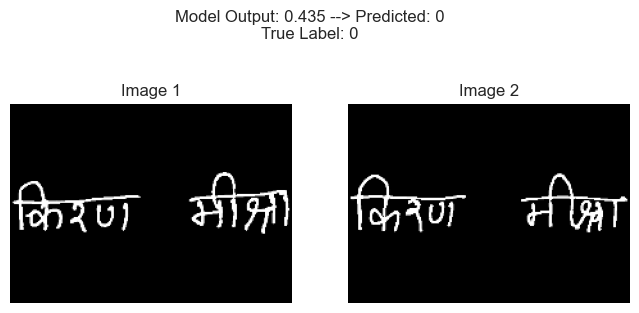

1/1 [==============================] - 0s 24ms/step


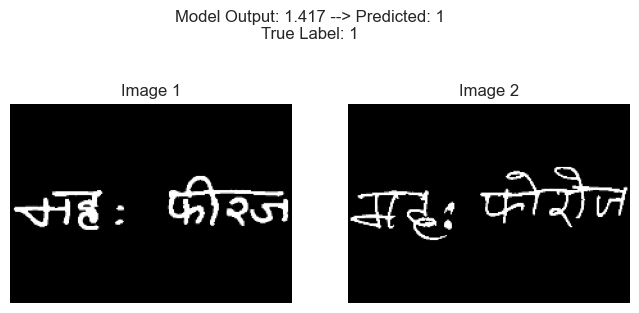

1/1 [==============================] - 0s 28ms/step


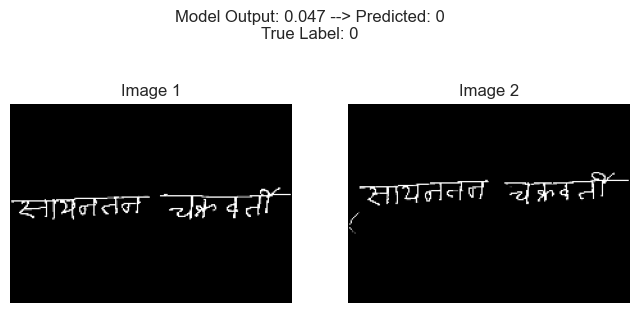

1/1 [==============================] - 0s 25ms/step


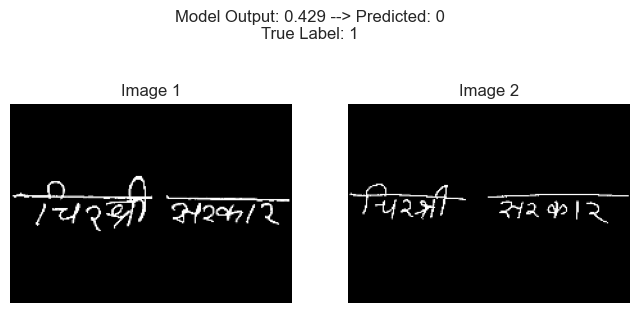

1/1 [==============================] - 0s 25ms/step


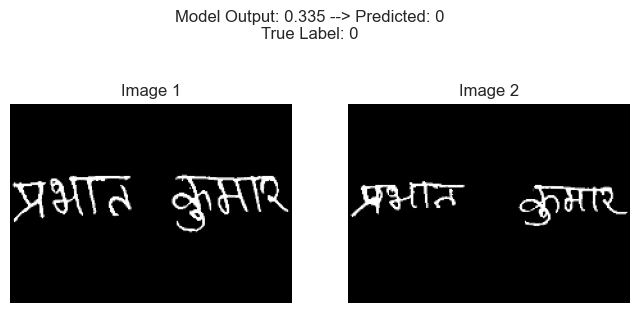

1/1 [==============================] - 0s 24ms/step


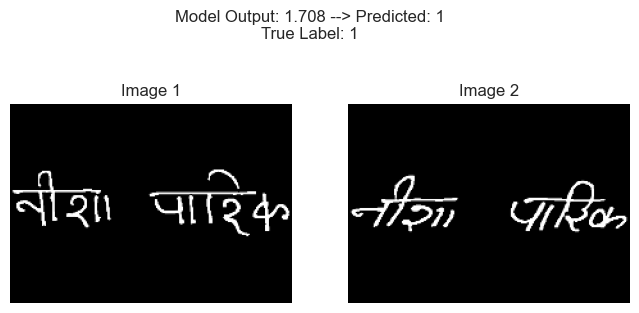

1/1 [==============================] - 0s 22ms/step


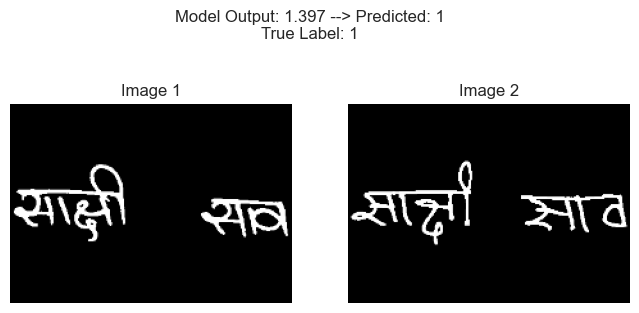

1/1 [==============================] - 0s 28ms/step


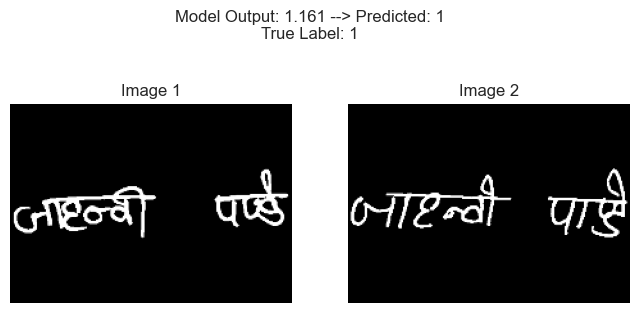

1/1 [==============================] - 0s 25ms/step


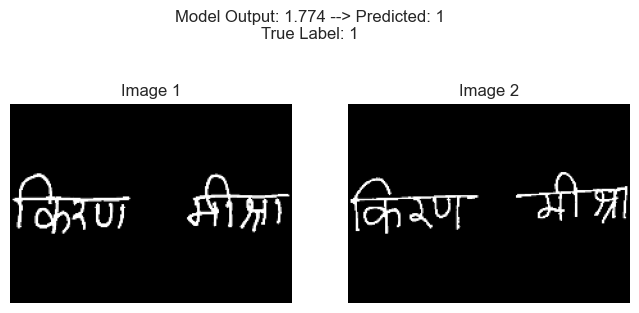

1/1 [==============================] - 0s 25ms/step


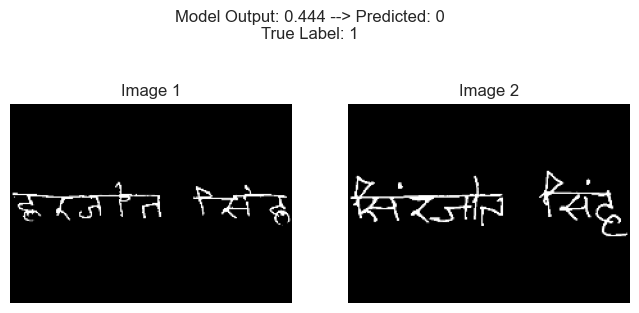

1/1 [==============================] - 0s 39ms/step


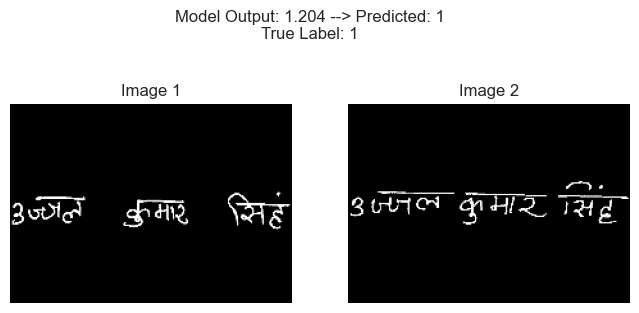

1/1 [==============================] - 0s 25ms/step


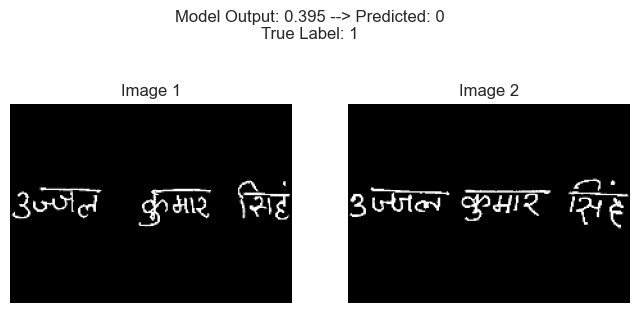

1/1 [==============================] - 0s 27ms/step


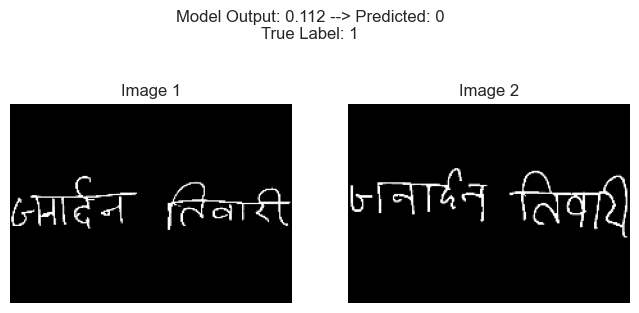

1/1 [==============================] - 0s 29ms/step


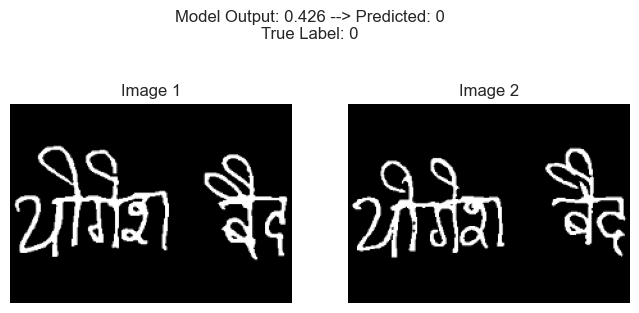

1/1 [==============================] - 0s 33ms/step


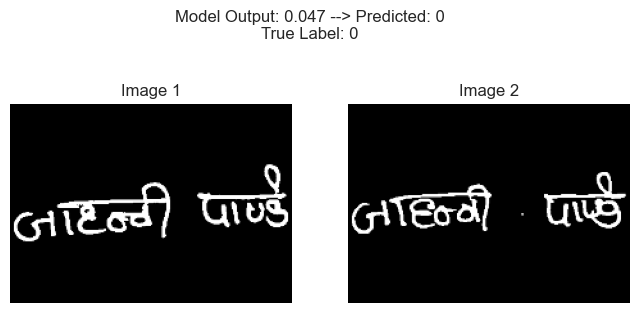

1/1 [==============================] - 0s 41ms/step


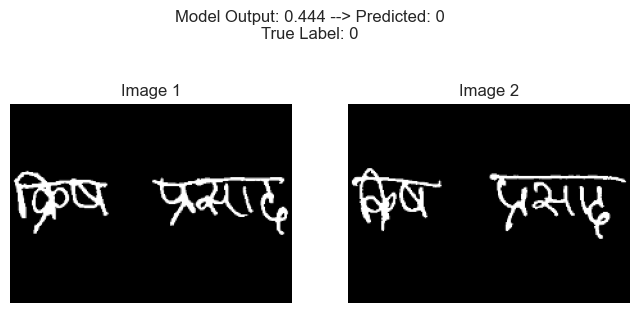

1/1 [==============================] - 0s 26ms/step


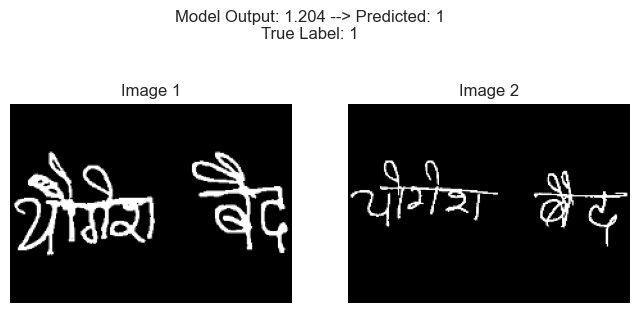

1/1 [==============================] - 0s 27ms/step


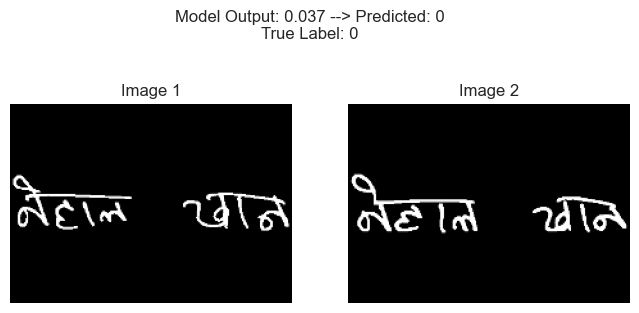

1/1 [==============================] - 0s 25ms/step


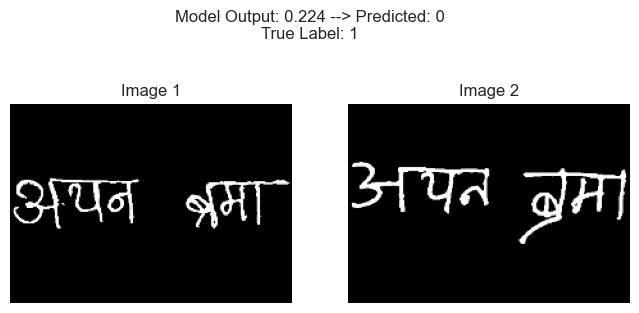

1/1 [==============================] - 0s 23ms/step


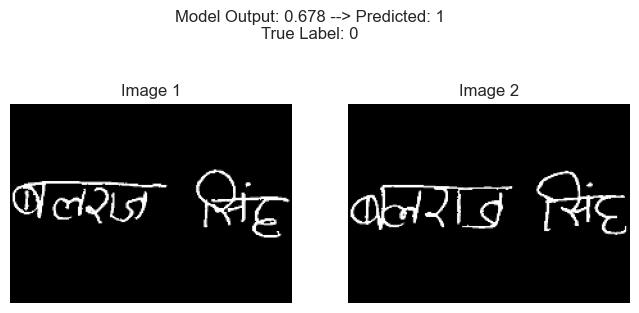

1/1 [==============================] - 0s 34ms/step


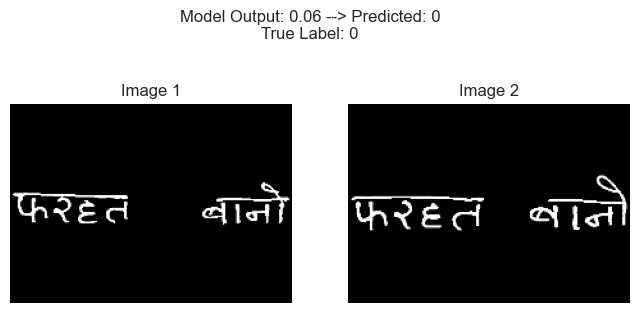

1/1 [==============================] - 0s 24ms/step


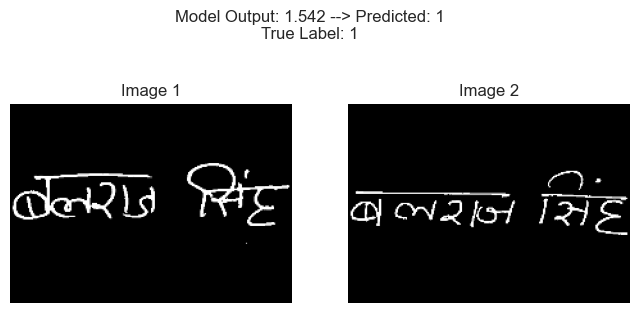

1/1 [==============================] - 0s 24ms/step


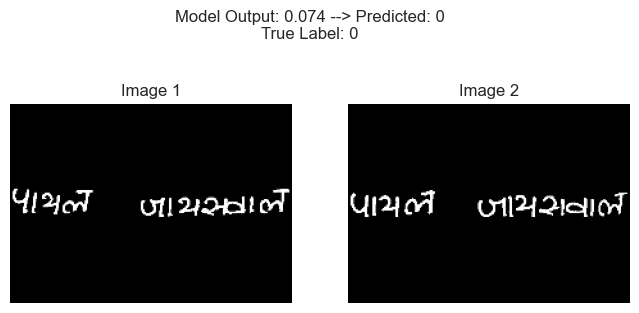

1/1 [==============================] - 0s 25ms/step


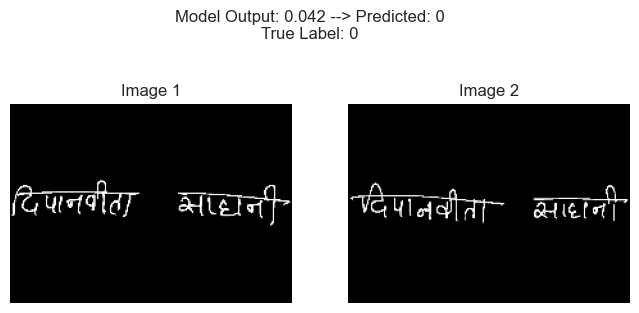

1/1 [==============================] - 0s 29ms/step


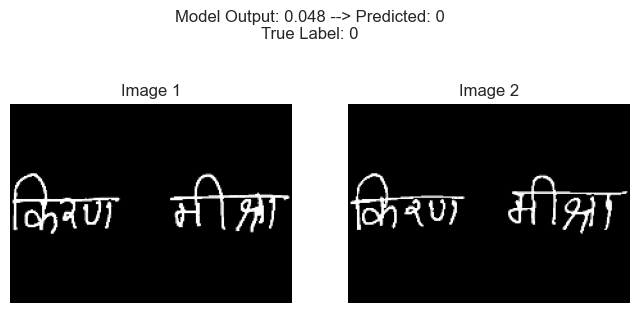

1/1 [==============================] - 0s 26ms/step


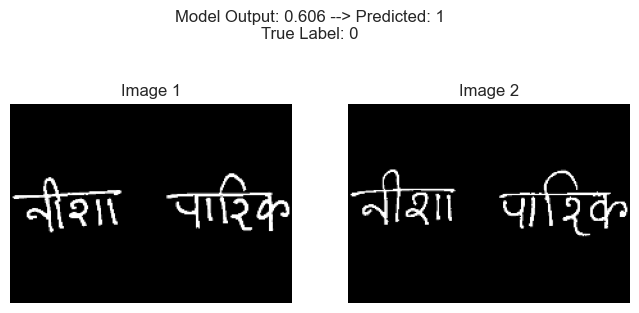

Accuracy of testing: 80.0%


In [156]:
def visualize_test_pairs(model, dataset, num_samples=20, threshold=0.5):
    """
    Visualizes test pairs from the dataset and displays the model predictions.

    Parameters:
    ----------
    model : keras.Model
        The trained Siamese model.

    dataset : tf.data.Dataset
        The test dataset containing pairs of images and labels.

    num_samples : int, optional
        The number of samples to visualize (default is 20).

    threshold : float, optional
        The threshold for classifying the output as similar (default is 0.5).
    """
    dataset_unbatched = dataset.unbatch()

    correct = 0

    for i, ((img1, img2), label) in enumerate(dataset_unbatched.take(num_samples)):
        img1_batch = tf.expand_dims(img1, axis=0)
        img2_batch = tf.expand_dims(img2, axis=0)

        pred = model.predict([img1_batch, img2_batch])[0][0]
        pred_rounded = round(float(pred), 3)
        prediction_class = 1 if pred > threshold else 0

        img1_np = img1.numpy().squeeze()
        img2_np = img2.numpy().squeeze()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax1.imshow(img1_np, cmap='gray')
        ax1.set_title("Image 1")
        ax1.axis('off')
        ax2.imshow(img2_np, cmap='gray')
        ax2.set_title("Image 2")
        ax2.axis('off')

        fig.suptitle(
            f"Model Output: {pred_rounded} --> Predicted: {prediction_class}\n"
            f"True Label: {int(label)}",
            fontsize=12
        )
        plt.show()

        if prediction_class == int(label):
            correct+=1

        if i == num_samples - 1:
            print(f"Accuracy of testing: {correct/num_samples*100}%")
            break


visualize_test_pairs(siamese_model, test_dataset, num_samples=100, threshold=0.5)

In [158]:
def one_shot_test(author_ids, query_author_id, dataset_path, siamese_model, n=10, k=1):
    """
    Perform one-shot testing with visualization of image pairs.

    Args:
        author_ids (list): List of author IDs.
        query_author_id (int): ID of the query author.
        dataset_path (str): Base directory path where the dataset is stored.
        siamese_model (Model): Pre-trained Siamese model.
        n (int): Number of classes for n-way one-shot testing.

    Returns:
        dict: Dictionary containing similarity scores and pair types.
    """
    total_correct = 0

    for trial in range(k):
        negative_candidates = []
        query_image = None
        positive_pair = None

        for author in author_ids:
            author_dir = os.path.join(dataset_path, str(author))

            if "CEDAR" in dataset_path:
                genuine_list = [os.path.join(author_dir, f) for f in os.listdir(author_dir) if f.startswith("original")]
            else:
                genuine_list = [os.path.join(author_dir, f) for f in os.listdir(author_dir) if "-G-" in f]

            if author == query_author_id:
                query_image = random.choice(genuine_list)
                positive_pair = random.choice([img for img in genuine_list if img != query_image])
            else:
                negative_candidates.extend(genuine_list)

        selected_negatives = random.sample(negative_candidates, n - 1)

        test_pairs = [(query_image, positive_pair)] + [(query_image, neg) for neg in selected_negatives]

        query_image_data = preprocessing(query_image, (IMG_HEIGHT, IMG_WIDTH))
        query_image_data = tf.expand_dims(query_image_data, axis=0)

        similarity_scores = []
        for idx, (img1_path, img2_path) in enumerate(test_pairs):
            img2_data = preprocessing(img2_path, (IMG_HEIGHT, IMG_WIDTH))
            img2_data = tf.expand_dims(img2_data, axis=0)

            similarity_score = siamese_model.predict([query_image_data, img2_data])[0][0]
            similarity_scores.append(similarity_score)

        max_index = np.argmin(similarity_scores)
        if max_index == 0:
            total_correct += 1

        if k == 1:
            for idx, (img1_path, img2_path) in enumerate(test_pairs):
                pair_type = "Positive" if idx == 0 else "Negative"
                visualize_pair(img1_path, img2_path, similarity_scores[idx], pair_type)

    accuracy = total_correct / k
    return accuracy

def visualize_pair(img1_path, img2_path, similarity_score, pair_type):
    """
    Visualizes a pair of images along with their similarity score.

    Args:
        img1_path (str): Path to the first image.
        img2_path (str): Path to the second image.
        similarity_score (float): The similarity score between the two images.
        pair_type (str): Indicates whether the pair is Positive or Negative.
    """
    if isinstance(similarity_score, np.ndarray):
        similarity_score = similarity_score.item()

    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(f"{pair_type} Pair\nSimilarity: {similarity_score:.4f}")
    axes[1].axis("off")
    plt.show()

query_author_id = random.choice(test_authors)
result = one_shot_test(test_authors, query_author_id, choosen_dataset, siamese_model, n=5, k=10)
print(f"One-shot testing accuracy over {100} trials: {result * 100:.2f}%")


1/1 [==============================] - 0s 24ms/step
One-shot testing accuracy over 100 trials: 30.00%
